# Preliminaries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import sys
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append("/Users/paolo/Documents/methods/CMI_FS")
from feature_selection import forwardFeatureSelection

sys.path.append("/Users/paolo/Documents/methods/LinCFA")
from LinCFA import LinCFA

sys.path.append("/Users/paolo/Documents/Droughts/Paolo/regression_LinCFA")
from aux import standardize,unfold_dataset,compute_r2,prepare_target,prepare_features,aggregate_unfolded_data,FS_with_linearWrapper,compare_methods


In [2]:
def plot_cells(output,selected_colnames, xmin=9, xmax=11, ymin=44, ymax=45.5):
    x = []
    y = []
    colors = cm.rainbow(np.linspace(0,1,len(output)))
    np.random.shuffle(colors)
    fig, ax = plt.subplots(2)
    ax[0].set_xlim(xmin,xmax)
    ax[1].set_xlim(xmin,xmax)
    ax[0].set_ylim(ymin,ymax)
    ax[1].set_ylim(ymin,ymax)
    for i in range(len(output)): 
        #print(len(output[i]))
        x = []
        y = []
        
        for datum in output[i]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[0].scatter(x,y,color=colors[i])
    
    x = []
    y = []
    col = cm.rainbow(np.linspace(0,1,len(selected_colnames)))
    for i in range(len(selected_colnames)): 
        idx = int(selected_colnames[i].split('_')[-1])
        for datum in output[idx]:
            x.append(float(datum.split('_')[1]))
            y.append(float(datum.split('_')[2]))
        ax[1].scatter(x,y,color=col[i])
    

In [3]:
### Nota: devo standardizzare tutto prima di chiamare LinCFA ma non serve validare
# infatti il metodo usa i dati per stimare i pesi della regressione lineare
# anche per CMI_FS non serve validare, usa i dati per quantificare l'informazione condivisa col target

# Target 

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  0.282703
3    2001-01-29  0.417470    0.44  2001     5 -0.030490
4    2001-02-06  0.492202    0.53  2001     6  0.451097
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.436464    0.46  2009    48  0.091910
407  2009-12-05  0.466152    0.49  2009    49  0.283224
408  2009-12-13  0.553659    0.59  2009    50  0.847138
409  2009-12-21  0.507978    0.65  2009    52  0.552758
410  2009-12-29  0.083046    0.00  2009    53 -2.185583

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))


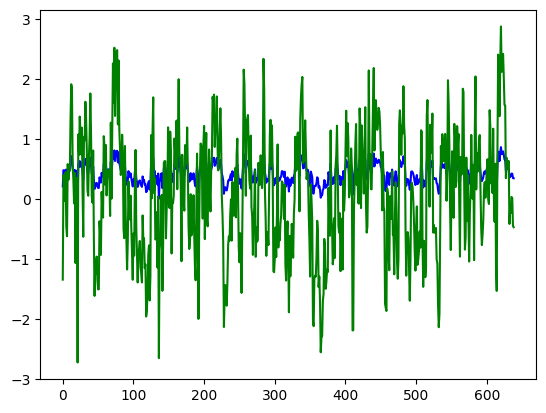

In [3]:
### target stops in 2019
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
plt.plot(target_df_trainVal.loc[:,'mean'], color='blue')
plt.plot(target_df_trainVal.loc[:,'mean_std'], color='green')

# All features, all basins

## Features

In [4]:
path='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg'

df_test_unfolded_std = pd.DataFrame()
df_trainVal_unfolded_std = pd.DataFrame()

for col in ['cyclostationary_mean_tg', 
            'cyclostationary_mean_tg_1w',
            'cyclostationary_mean_tg_4w', 
            'cyclostationary_mean_tg_8w',
            'cyclostationary_mean_tg_12w', 
            'cyclostationary_mean_tg_16w',
            'cyclostationary_mean_tg_24w',
           'cyclostationary_mean_rr', 
            'cyclostationary_mean_rr_1w',
            'cyclostationary_mean_rr_4w', 
            'cyclostationary_mean_rr_8w',
            'cyclostationary_mean_rr_12w', 
            'cyclostationary_mean_rr_16w',
            'cyclostationary_mean_rr_24w']:
    df_train_unfolded_std_loc,df_val_unfolded_std_loc,df_test_unfolded_std_loc,df_trainVal_unfolded_std_loc = prepare_features(path,col,max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', multiple=True)
    df_trainVal_unfolded_std_loc = df_trainVal_unfolded_std_loc.add_prefix(col)
    df_trainVal_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_trainVal_unfolded_std_loc], axis=1)
    df_test_unfolded_std_loc = df_test_unfolded_std_loc.add_prefix(col)
    df_test_unfolded_std = pd.concat([df_test_unfolded_std, df_test_unfolded_std_loc], axis=1)

df_trainVal_unfolded_std.head()

,cyclostationary_mean_tgmean_12.149860342381333_43.74986055078544,cyclostationary_mean_tgmean_12.149860342381333_43.8498605504681,cyclostationary_mean_tgmean_12.149860342381333_43.94986055015075,cyclostationary_mean_tgmean_12.149860342381333_44.04986054983341,cyclostationary_mean_tgmean_12.149860342381333_44.14986054951606,cyclostationary_mean_tgmean_12.149860342381333_44.24986054919872,cyclostationary_mean_tgmean_12.149860342381333_44.34986054888138,cyclostationary_mean_tgmean_12.149860342381333_44.44986054856403,cyclostationary_mean_tgmean_12.149860342381333_44.54986054824669,cyclostationary_mean_tgmean_12.149860342381333_44.64986054792934,...,cyclostationary_mean_rr_24wmean_9.949860351182458_44.849860547294654,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305
0,0.719982,0.737633,0.791074,0.848973,0.983768,1.172439,1.201792,1.127842,0.986823,0.794499,...,4.633165,4.275220,4.804841,3.783344,2.023797,1.738511,3.017236,2.808310,2.903963,3.306185
1,1.845931,2.162888,2.278888,2.313132,2.330406,2.363919,2.119857,2.008556,1.797622,1.626867,...,3.258669,4.218524,4.692536,3.555257,2.355244,0.503774,1.109312,1.020964,2.003819,1.909813
2,-0.312107,-0.404970,-0.361520,-0.116017,0.037568,0.199148,0.215971,0.233859,0.106281,-0.117314,...,2.983529,2.815001,3.107059,2.416648,1.626289,0.184162,0.502990,0.333127,1.026544,0.929751
3,1.666516,1.661740,1.601745,1.595421,1.579804,1.588420,1.391649,1.185715,1.141724,0.968893,...,2.228901,2.045116,2.811179,1.785545,1.172727,-0.277898,-0.128053,-0.245722,0.482495,0.353457
4,-0.031846,-0.003213,-0.013352,0.122002,0.295776,0.473944,0.532393,0.421560,0.238369,-0.025356,...,1.434718,1.190746,1.802918,0.990035,0.539199,0.602205,0.513759,0.099714,0.185020,0.490890


## temperature

### wrapper

In [5]:
filter_col = [col for col in df_trainVal_unfolded_std if col.startswith('cyclostationary_mean_tg')]

selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std[filter_col], target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.07626615460505604
actual validation score: 0.2864963351223545, number of remaining columns: 6935

actual training score: 0.09005360806532436
actual validation score: 0.35654270732173654, number of remaining columns: 6934

actual training score: 0.10313133793705664
actual validation score: 0.3825146412870445, number of remaining columns: 6933

actual training score: 0.12457027701682277
actual validation score: 0.40803820011704395, number of remaining columns: 6932

actual training score: 0.1559378936314777
actual validation score: 0.4326656246018826, number of remaining columns: 6931

actual training score: 0.1626867849136111
actual validation score: 0.4514326590963942, number of remaining columns: 6930

actual training score: 0.17900462358719527
actual validation score: 0.48825413987744437, number of remaining columns: 6929

actual training score: 0.18441534063985454
actual validation score: 0.5034074435975655, number of remaining columns: 6928

actual training

Full aggregate regression train score: 1.0, test score: -9.25931821234243
Aggregate regression train score with FS: 0.45269695893103046, test score: -1.009518943407723


In [6]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -9.25931821234243
Aggregate regression train score with FS: 0.24710235017139492, test score: -0.012624154769504514


### CMI FS

In [7]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std[filter_col]),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std[filter_col].columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(1929, 0.15246918228231238), (961, 0.14998699676357055), (960, 0.14933536712992324), (965, 0.14860373806543736), (757, 0.14553530924467203), (829, 0.14314293874625258), (336, 0.14254955357731547), (1904, 0.1414417335986945), (966, 0.1412488284588791), (1109, 0.14010528877808637), (751, 0.1400350398045634), (748, 0.13975709725677637), (692, 0.13930561897650673), (665, 0.138657819755087), (1928, 0.13829747463732578), (1327, 0.1378938752506051), (275, 0.1377948913850727), (573, 0.13678834355637548), (1958, 0.13678309275993097), (1189, 0.13653741354012167), (1920, 0.13581585309537378), (684, 0.13496708664839488), (752, 0.1349471030987045), (963, 0.1349170730411436), (1200, 0.1341624215138366), (683, 0.13370736679082068), (912, 0.1336253951612861), (173, 0.1331824996521766), (1824, 0.13277077435426196), (967, 0.13270113122246438), (833, 0.1326441028111571), (905, 0.13247441716956537), (742, 0.1321612989041681), (225, 0.1320161251059858), (741, 0.13168952030710382), (4

CMI: 0.0018289590828271252
CMI: 0.0038584436936041078
CMI: 0.005081511967867991
CMI: 0.005030168523970507
CMI: 0.009085449524248584
CMI: 0.006442759705948403
CMI: 0.01442590184666856
CMI: 0.005289622591796744
CMI: 0.002834436386154854
CMI: 0.007381770633577728
CMI: 0.004406833236565627
CMI: 0.0001748905198913353
CMI: 0.0032687516758555524
CMI: 0.009931643863583112
CMI: 0.003445985586878142
CMI: 0.003321015633973523
CMI: 0.00863404969133802
CMI: 0.00405363502391487
CMI: 0.0003430673319137767
CMI: 0.009636507983069281
CMI: 0.007660385543579812
CMI: 0.0014879609370545555
CMI: 0.01073896325312168
CMI: 0.005831876763465804
CMI: 0.01797275025534223
CMI: 0.011799283082750134
CMI: 0.014392881777865463
CMI: 0.0006988343346207293
CMI: 0.010585983755223793
CMI: 0.005409467491213293
CMI: 0.012681755578934223
CMI: 0.005999105078006106
CMI: 0.0022097606595902763
CMI: 0.01889355970263082
CMI: 0.013486366244341463
CMI: 0.0051286607594487055
CMI: 0.002813499803023034
CMI: 0.011534482408338709
CMI: 0.00

CMI: 0.006717097270537292
CMI: 0.005756748929850092
CMI: 0.0077284229233966495
CMI: 0.0068254389186493125
CMI: 0.013858849869288203
CMI: 0.00787717987955
CMI: 0.0040424563945329894
CMI: 0.0024502829971582707
CMI: 0.008692697053655912
CMI: 0.00450928739551032
CMI: 0.008762085904742145
CMI: 0.0031893444174457275
CMI: 0.000244719157984824
CMI: 0.009053352925459113
CMI: 0.005062239130919327
CMI: 0.004654834429735383
CMI: 0.004049585689130386
CMI: 0.015472191664155477
CMI: 0.006648349096473077
CMI: 0.005983025211966669
CMI: 0.0038017186475606812
CMI: 0.011542183661137267
CMI: 0.016613984569896906
CMI: 0.0188161150455948
CMI: 0.011796357496403814
CMI: 0.0006645098923235837
CMI: 0.019521855194740173
CMI: 0.013539509041781167
CMI: 0.015739384818693358
CMI: 0.016844310433094395
CMI: 0.016578416977342247
CMI: 0.022401443887561545
CMI: 0.014262649805126454
CMI: 0.011982228885402235
CMI: 0.00867607596054698
CMI: 0.013586667619983728
CMI: 0.023405313596613436
CMI: 0.03198777208093212
CMI: 0.0170558

CMI: 0.011345735164722176
CMI: 0.006153923616918661
CMI: 0.01688050508443112
CMI: 0.0006561817961142635
CMI: 0.009835720542014176
CMI: 0.009183919203510332
CMI: 0.007532636321969044
CMI: 0.004105810136148913
CMI: 0.004714390688194486
CMI: 0.0074021922967594245
CMI: 0.003729802595183712
CMI: 0.0068044216211117226
CMI: 0.00525530186800241
CMI: 0.006082302455012928
CMI: 0.011413619092927596
CMI: 0.005704648878619101
CMI: 0.005004383733777346
CMI: 0.009024440104272502
CMI: 0.007645885985552187
CMI: 0.00805297413174294
CMI: 0.004208624468956229
CMI: 0.013054178046263798
CMI: 0.014466543141419569
CMI: 0.006275567843234686
CMI: 0.006329017810002002
CMI: 0.009304383215460066
CMI: 0.003989489148974651
CMI: 0.004268791342463885
CMI: 0.007788019516788813
CMI: 0.01399886121128785
CMI: 0.008977741062753841
CMI: 0.00443480117375239
CMI: 0.005564888538352547
CMI: 0.01660531867824394
CMI: 0.003727418533121668
CMI: 0.0068642988806812966
CMI: 0.0007248545294067932
CMI: 0.002085636398430374
CMI: 0.003547

CMI: 0.0012252812603019136
CMI: 0.004134078320293305
CMI: 0.0031988729749610756
CMI: 0.0064001400257922
CMI: 0.0001323793120111827
CMI: 0.002520425782765734
CMI: 0.003830665980240483
CMI: 0.00403737143279434
CMI: 0.002506947181251079
CMI: 0.004150222484497784
CMI: 0.005203826010696994
CMI: 0.0020510608617723414
CMI: 0.0043196887027969755
CMI: 0.0009499774067726341
CMI: 0.0027826137323962163
CMI: 0.005085048242411461
CMI: 0.002440134940444455
CMI: 0.0026291851502737162
CMI: 0.005160867412116993
CMI: 0.003157206110123434
CMI: 0.00010723479046798046
CMI: 0.0009830911799412756
CMI: 0.013074060942750654
CMI: 0.0011454619717778391
CMI: 0.0051516075317793175
CMI: 0.013949133585230117
CMI: 0.009974129409955651
CMI: 0.03540895282806136
CMI: 0.00293404194251215
CMI: 0.00032076499102628997
CMI: 0.0014220279571966477
CMI: 0.007039962880553974
CMI: 0.003563677493265305
CMI: 0.0002461413152825831
CMI: 0.011624881468101506
CMI: 0.0007503613527005404
CMI: 0.009441119203132065
CMI: 0.012139581772340369

CMI: 0.01821498080448744
CMI: 0.004812131791093632
CMI: 0.012957774149795598
CMI: 0.0047530503379722144
CMI: 0.013993297999275484
CMI: 0.026467871452209524
CMI: 0.016374227684097353
CMI: 0.016807097614639416
CMI: 0.01096245733742282
CMI: 0.00019771258546064097
CMI: 0.020323580797100116
CMI: 0.005763586199599546
CMI: 0.018968675329225193
CMI: 0.004331968180289469
CMI: 0.010091123018957204
CMI: 0.007639552785707271
CMI: 0.00028210447872667466
CMI: 0.011867928287958573
CMI: 0.004694172396231322
CMI: 0.011550867744440196
CMI: 0.0009247216688028359
CMI: 0.001790233472865832
CMI: 0.0009524621673963896
CMI: 0.005870410160945416
CMI: 0.00121587369189613
CMI: 0.006163427480809669
CMI: 0.010658972802808336
CMI: 0.023105757236038
CMI: 0.01862116988367285
CMI: 0.004384327629232326
CMI: 0.005905458580653139
CMI: 0.002734792254381946
CMI: 0.0056639842935106155
CMI: 0.0011377823570869472
CMI: 0.000532074901725299
CMI: 0.0029199308862632722
CMI: 2.9796955008737358e-05
CMI: 0.00038290715059832725
CMI: 

CMI: 0.010848847692025404
CMI: 0.006831691052116284
CMI: 0.0016779073169043979
CMI: 0.001889179956973186
CMI: 0.0036986069915282693
CMI: 0.00029698506580361217
CMI: 0.0036592451663867986
CMI: 0.007887544659683304
CMI: 0.0033928571711596966
CMI: 0.005801963562144019
CMI: 0.007152667697156445
CMI: 0.002434459696626118
CMI: 0.006068827795147169
CMI: 0.004251583773522888
CMI: 0.009132522247331576
CMI: 0.0035016699191701417
CMI: 0.0018484149465193556
CMI: 0.002121889923061143
CMI: 0.006079524868711245
CMI: 0.0022517012035386252
CMI: 9.675669328271241e-05
CMI: 0.004889445461723818
CMI: 0.004816236611280056
CMI: 2.1360707565726278e-05
CMI: 0.0014295010407888442
CMI: 0.010472393393179874
CMI: 0.009186798366634857
CMI: 0.002861027982954678
CMI: 0.012723648937754739
CMI: 0.008057073880079979
CMI: 0.004321201160128685
CMI: 0.0040518628250229005
CMI: 0.007585273836045098
CMI: 0.01253052419705214
CMI: 0.006210977180639482
CMI: 0.00781732044783967
CMI: 0.0031549636259946834
CMI: 0.013829422517344037

CMI: 0.02645297442196662
CMI: 0.002636559812845718
CMI: 0.005943049722716781
CMI: 0.007914140914131118
CMI: 0.01603351380923798
CMI: 0.015848584281281913
CMI: 0.001785985921473554
CMI: 0.004667438764916904
CMI: 0.004747060805871922
CMI: 0.014358187207742346
CMI: 0.007889898541815765
CMI: 0.004625403064292377
CMI: 0.011964239343471572
CMI: 0.006163208735250142
CMI: 0.014025779897005125
CMI: 0.014591953699695986
CMI: 0.005134506220929758
CMI: 0.0012386018443213964
CMI: 0.0016987156745154885
CMI: 0.008157657748474961
CMI: 0.00431237941854723
CMI: 0.010743430458073744
CMI: 0.018381612472038428
CMI: 0.028432455597531603
CMI: 0.009630766399349844
CMI: 0.02233632253277834
CMI: 0.004574941660796528
CMI: 0.01191984210022598
CMI: 0.007201757754922045
CMI: 0.015374666185978159
CMI: 0.010240458715167794
CMI: 0.009071730158063618
CMI: 0.006389725625525505
CMI: 0.022574052793417648
CMI: 0.0035439596175681487
CMI: 0.012886416088499164
CMI: 0.009904773192930622
CMI: 0.007336949382122926
CMI: 0.0049728

CMI: 0.007711692648684154
CMI: 0.00959336681496803
CMI: 0.0004830140584088094
CMI: 0.0031015763064753954
CMI: 0.009288758955184329
CMI: 0.015041675572228519
CMI: 0.010589026885719749
CMI: 0.009687168224025822
CMI: 0.015786671862338064
CMI: 0.0058965307720691695
CMI: 0.0020460097238745867
CMI: 0.01345928324381293
CMI: 0.017498459186542886
CMI: 0.008496374498925235
CMI: 0.005653464496093441
CMI: 0.006539533372732553
CMI: 0.0010792191834667064
CMI: 0.009044956091010997
CMI: 0.010554962917261684
CMI: 0.006640231878084241
CMI: 0.00913319813370364
CMI: 0.007996597154766888
CMI: 0.007012193504315506
CMI: 0.013147944497679004
CMI: 0.013537721180943096
CMI: 0.004683849507227805
CMI: 0.016430647916385793
CMI: 0.013301497630161252
CMI: 0.004941503551021881
CMI: 0.006166262838809139
CMI: 0.0040656800018494255
CMI: 0.0005196365683055593
CMI: 0.010937895216341614
CMI: 0.003455069969184238
CMI: 0.008415815699120782
CMI: 0.0014392875996143417
CMI: 0.0009796077055951313
CMI: 0.005513058639994156
CMI: 0

CMI: 0.00529630660718039
CMI: 0.006275758955481048
CMI: 0.001819561173942441
CMI: 0.0017870349606706193
CMI: 0.0013751997198970245
Highest CMI score: 0.006275758955481048
Adding original feature: 6426
CMI: 0.0002831510064510989
CMI: 2.5517836298005747e-05
CMI: 4.0873293677357037e-05
CMI: 0.0011836305248172918
CMI: 6.500491307498413e-05
Highest CMI score: 0.0011836305248172918
Adding original feature: 1391
CMI: 6.0866567007322736e-05
CMI: 0.00016472061809974514
CMI: 0.00044779111305093267
Highest CMI score: 0.00044779111305093267
Adding original feature: 1489
CMI: 6.086656700737825e-05
CMI: 0.00014772852838934591
Highest CMI score: 0.00014772852838934591
Adding original feature: 1379
CMI: 9.22515772753818e-05
Highest CMI score: 9.22515772753818e-05
Adding original feature: 1378
Highest CMI score: -0.00020936229679308083

[1929, 2616, 6326, 1565, 1490, 1843, 6888, 1821, 1328, 1364, 1392, 6269, 1954, 6426, 1391, 1489, 1379, 1378]

Full aggregate regression train score: 1.0, test score: -9

In [8]:
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -15.7349849010062
Aggregate regression train score with FS: 0.1685839934277893, test score: 0.22924608342781871


## precipitation

### wrapper

In [9]:
filter_col = [col for col in df_trainVal_unfolded_std if col.startswith('cyclostationary_mean_rr')]

selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std[filter_col], target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.11103533669120969
actual validation score: 0.25690845642017135, number of remaining columns: 6935

actual training score: 0.12908456690173387
actual validation score: 0.30167694561664193, number of remaining columns: 6934

actual training score: 0.14101905098515954
actual validation score: 0.3433791250374544, number of remaining columns: 6933

actual training score: 0.16334563265185342
actual validation score: 0.36617989572801624, number of remaining columns: 6932

actual training score: 0.1783356166653135
actual validation score: 0.3917498764991002, number of remaining columns: 6931

actual training score: 0.1879734702342255
actual validation score: 0.4144889122754635, number of remaining columns: 6930

actual training score: 0.19421280445107247
actual validation score: 0.4322621154500863, number of remaining columns: 6929

actual training score: 0.19657506958583348
actual validation score: 0.4465021468530699, number of remaining columns: 6928

actual training

Full aggregate regression train score: 1.0, test score: -26.065088722614004
Aggregate regression train score with FS: 0.43122230518643145, test score: -1.4124405891513256


In [10]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -26.065088722614004
Aggregate regression train score with FS: 0.2516000247467822, test score: 0.11192637388973692


### CMI FS

In [11]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std[filter_col]),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std[filter_col].columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(2086, 0.15602213842520823), (1997, 0.1525336077694899), (2124, 0.15047888316668728), (1983, 0.14965838393601869), (1097, 0.144196187518918), (2060, 0.14218951220585083), (996, 0.14178884797173272), (1020, 0.14123986281259757), (5780, 0.13982205921709673), (5024, 0.13919208390467547), (3146, 0.13880788403165495), (2973, 0.13804379449464171), (3005, 0.13758334494854949), (2099, 0.13653454608737195), (3871, 0.13605075049878657), (5525, 0.13408811036773696), (5469, 0.13366529234664476), (2061, 0.1334117319192885), (1982, 0.1326933775679204), (5774, 0.13133096909996878), (2893, 0.12874077211883111), (2000, 0.12872834158016044), (3038, 0.12849477318341976), (2091, 0.1284889284685272), (2066, 0.12821219324183483), (2879, 0.1277889705384366), (2974, 0.12750886215708865), (3167, 0.12688962889647015), (3877, 0.1268241207271313), (4137, 0.12668916836884958), (2978, 0.12635785133066796), (5768, 0.12606433336922496), (5732, 0.12586327160251964), (2047, 0.1258050277289693), (

CMI: 0.0029835825937166716
CMI: 0.0001403627412776276
CMI: 0.0021230221810962513
CMI: 0.002962446342996111
CMI: 0.0026814146443295828
CMI: 0.004185557433634801
CMI: 0.008161713931022774
CMI: 0.021567794782229727
CMI: 0.0007492078308471706
CMI: 0.0072669559096182335
CMI: 0.01017812309527183
CMI: 0.007851326722386559
CMI: 0.0008359130157221673
CMI: 0.0020937943307995643
CMI: 0.004051981692690637
CMI: 0.004824808097281447
CMI: 0.00037211581153506756
CMI: 0.009928621888821265
CMI: 0.00987357745907283
CMI: 0.009783894656878817
CMI: 0.005807725871191355
CMI: 0.018305652335302874
CMI: 0.0009698705596163648
CMI: 0.010018114613105311
CMI: 0.003981662613057602
CMI: 0.003262847738819963
CMI: 0.007010963122520725
CMI: 0.0008649210326165668
CMI: 0.0034415934387108937
CMI: 0.012139313345696817
CMI: 0.0070233940650843985
CMI: 0.0004804251964117823
CMI: 0.00182220091627186
CMI: 0.011844147941633076
CMI: 0.01635444625650767
CMI: 0.0014003198821457008
CMI: 0.00013168175422867412
CMI: 0.00248700558799963

CMI: 0.001056436473890976
CMI: 0.007752947159538809
CMI: 0.015473349936062558
CMI: 0.001642298153216204
CMI: 0.002406787990651943
CMI: 0.0009250007758415391
CMI: 0.0010506281898279568
CMI: 0.001825664256105558
CMI: 0.0036202230925059253
CMI: 0.008462445851806139
CMI: 0.007317598562538746
CMI: 0.013699306265761185
CMI: 0.0018050777528996476
CMI: 2.373878282557751e-05
CMI: 0.00389148884062962
CMI: 0.00041612476389943365
CMI: 0.004945723085694909
CMI: 0.0007306404684938039
CMI: 0.002934373618284386
CMI: 0.0004483041781838948
CMI: 0.003606095566460049
CMI: 0.0028048284464679274
CMI: 0.01012282433606504
CMI: 0.01175453690342293
CMI: 0.014662472934867915
CMI: 0.0027272564317266657
CMI: 0.015882481371764234
CMI: 0.011892565894354917
CMI: 0.01783621181638792
CMI: 0.010746537875765155
CMI: 0.007972529372212767
CMI: 0.003291084463138444
CMI: 0.0066945052299975105
CMI: 9.230170859508835e-05
CMI: 0.017903145868887388
CMI: 0.014247341105882688
CMI: 0.027886968886131402
CMI: 0.0024000527263735583
CM

CMI: 0.03472036958625599
CMI: 0.009315486050286564
CMI: 0.004309124685502236
CMI: 0.002984919441337941
CMI: 0.009062824593249419
CMI: 0.002469769820965334
CMI: 0.022306364486923247
CMI: 0.03232949810203872
CMI: 0.029928138659169462
CMI: 0.02620840788650447
CMI: 0.02273520956975414
CMI: 0.03581446696004825
CMI: 0.017744951682188703
CMI: 0.001504037265540492
CMI: 0.01640678310361368
CMI: 0.03224192826417477
CMI: 0.01562830515660013
CMI: 0.031767683750924675
CMI: 0.03137689994293871
CMI: 0.005030861361112443
CMI: 0.011143549197016545
CMI: 0.024061153229903293
CMI: 0.039594645449396976
CMI: 0.01949597206881276
CMI: 0.021620770583692134
CMI: 0.0011297631286590892
CMI: 0.022454525185585522
CMI: 0.014946780179888347
CMI: 0.013887279448489692
CMI: 0.01538918970531497
CMI: 0.04243748928523494
CMI: 0.00684988962150565
CMI: 0.015482762848582104
CMI: 0.018495721385846348
CMI: 0.02777696157219997
CMI: 0.025974428932025173
CMI: 0.011161803498782819
CMI: 0.024801655817156765
CMI: 0.004522277568519722

CMI: 0.0036239838654809897
CMI: 0.020221617321703772
CMI: 0.015803891877486986
CMI: 0.011292698079712865
CMI: 0.002462363236188564
CMI: 0.013506963307660852
CMI: 0.003386031036075876
CMI: 0.008800840873558008
CMI: 0.013000283046127659
CMI: 0.038799186848608974
CMI: 0.013760333851767892
CMI: 0.0026442835800704056
CMI: 0.0015127460948117233
CMI: 0.017166289628389425
CMI: 0.02586241925004501
CMI: 0.032592624909661666
CMI: 0.03775906901258544
CMI: 0.004460380668556252
CMI: 0.0014570971440729108
CMI: 0.016445593496525635
CMI: 0.041754338689104
CMI: 0.020778277185438704
CMI: 0.03703310769594925
CMI: 0.0023280421186255285
CMI: 0.007032853528768285
CMI: 0.0014043960598809913
CMI: 0.04092834614001695
CMI: 0.0499168084058306
CMI: 0.0265328116955581
CMI: 0.005289360178648617
CMI: 0.002409009642711041
CMI: 0.015990729027951622
CMI: 0.010650363820379871
CMI: 0.03128179989502952
CMI: 0.03212359650480523
CMI: 0.029055078691808733
CMI: 0.0329663268361742
CMI: 0.018112000363985248
CMI: 0.00686888113006

CMI: 0.01670799575821122
CMI: 0.015823551290428478
CMI: 0.012562914610666054
CMI: 0.006629199510083755
CMI: 0.018090319663511906
CMI: 0.014805304158657245
CMI: 0.004057859862227536
CMI: 5.009039488024225e-06
CMI: 0.004167803384484525
CMI: 0.00762721028064553
CMI: 0.00671339109252897
CMI: 0.0263186950757546
CMI: 0.012130073408703923
CMI: 0.015989651233592722
CMI: 0.015823806967744908
CMI: 0.023541192555056045
CMI: 0.02662243963571992
CMI: 0.005570428513986397
CMI: 0.013511230416015513
CMI: 0.027640289732325185
CMI: 0.022179565177099653
CMI: 0.004161744600162637
CMI: 0.019183386519015244
CMI: 0.015211165351394051
CMI: 0.016412368435133495
CMI: 0.01006403968668207
CMI: 0.018827528999246917
CMI: 0.016240423855836628
CMI: 0.00897881515475879
CMI: 0.009209025360361556
CMI: 0.014510378440488358
CMI: 0.011634756418037573
CMI: 0.019274395833702107
CMI: 0.021126968389508644
CMI: 0.009855604796282197
CMI: 0.022828934314583077
CMI: 0.005520514642814056
CMI: 0.018222633215470352
CMI: 0.023640835721

CMI: 0.009337841206776415
CMI: 0.0003273312907377812
CMI: 0.007107402239179383
CMI: 0.009254668920002762
CMI: 0.02300321116498147
CMI: 0.03395417360560404
CMI: 0.04071383025670938
CMI: 0.03672576252981108
CMI: 0.003607857126156244
CMI: 0.010327250247993497
CMI: 0.0025764825925480017
CMI: 0.020667215766730918
CMI: 0.04028643464845011
CMI: 0.03401097336628531
CMI: 0.056958419680228356
CMI: 0.04271051534103004
CMI: 0.0035143778802929904
CMI: 0.0009912869447780415
CMI: 0.011372798821857155
CMI: 0.02122332842742758
CMI: 0.02396647296159357
CMI: 0.032118876433142235
CMI: 0.027252774765502974
CMI: 0.04322620613771308
CMI: 0.04042478819848244
CMI: 0.04415606749174597
CMI: 0.0619889740116126
CMI: 0.0007927159870591283
CMI: 0.02109533797596086
CMI: 0.015002831591463178
CMI: 0.028791219204265833
CMI: 0.021387115935523143
CMI: 0.024360038598149586
CMI: 0.03128770578599896
CMI: 0.05286020499551028
CMI: 0.04404468493829092
CMI: 0.042085437127539954
CMI: 0.006091136632284583
CMI: 0.007446413924928674

CMI: 0.018034033237775443
CMI: 0.00856993288045746
CMI: 0.017909946841668134
CMI: 0.015530589142150109
CMI: 0.011629582885167189
CMI: 0.009208743102080807
CMI: 0.0008399111780769963
CMI: 0.015713457677965642
CMI: 0.013373794341184325
CMI: 0.011227164749616686
CMI: 0.0032425844971641082
CMI: 0.0047794448001357015
CMI: 0.012008589758430915
CMI: 0.016748491712220287
CMI: 0.011792728531848318
CMI: 0.00578846609261871
CMI: 0.02382740708580955
CMI: 0.032080623512904305
CMI: 0.021075041622455715
CMI: 0.008714365492403259
CMI: 0.004180414109155706
CMI: 0.001660204687587652
CMI: 0.00797300550786953
CMI: 0.020609787287700354
CMI: 0.025754505322160254
CMI: 0.011226512274929434
CMI: 0.01020435472454806
CMI: 0.01752158224568212
CMI: 0.0010590644835745122
CMI: 0.014816271431111666
CMI: 0.00942999501939451
CMI: 0.01175239708305742
CMI: 0.013640466569791648
CMI: 0.0022461170774250028
CMI: 0.005781366605890931
CMI: 0.01246784794632591
CMI: 0.018877190931221532
CMI: 0.022210755501127527
CMI: 0.021274284

CMI: 0.008004982776023711
CMI: 0.0024748094684790833
CMI: 0.004538547518988245
CMI: 0.02193554332684794
CMI: 0.02113856292339092
CMI: 0.012778660315524132
CMI: 0.00678834931045269
CMI: 0.03158242015891416
CMI: 0.019367430096641325
CMI: 0.004355849405850376
CMI: 0.014396321500084908
CMI: 0.022307368741323802
CMI: 0.009944007082450801
CMI: 0.013102448906788133
CMI: 0.012512737516441524
CMI: 0.005198733298641567
CMI: 0.013529863451690494
CMI: 0.004013457920519464
CMI: 0.028729513871226048
CMI: 0.035177798174080815
CMI: 0.029107449667572033
CMI: 0.006630565022790108
CMI: 0.014771855967114639
CMI: 0.011565408938134097
CMI: 0.003210612085014275
CMI: 0.013985264994457292
CMI: 0.00954238715706332
CMI: 0.02658698391840833
CMI: 0.030915809435137942
CMI: 0.01477260241275874
CMI: 0.019510004529773695
CMI: 0.007284536774816525
CMI: 0.011758117803206541
CMI: 0.015572171822866882
CMI: 0.00851315934200586
CMI: 0.003202755994518608
CMI: 0.018534966202908343
CMI: 0.016419668062111148
CMI: 0.032663873805

CMI: 0.0016116159681625053
CMI: 0.019845211343348185
CMI: 0.018141517723930745
CMI: 0.025726159828068917
CMI: 0.015732087388635907
CMI: 0.0130067097031967
CMI: 0.012476135293805646
CMI: 0.007767674570346356
CMI: 0.009047840207052682
CMI: 0.04199050241861241
CMI: 0.038023156854111395
CMI: 0.025548414259529917
CMI: 0.04542124915014606
CMI: 0.03724020688379373
CMI: 0.03275288394318404
CMI: 0.006985391535355462
CMI: 0.0378404645037729
CMI: 0.030186995514464604
CMI: 0.008286826291483002
CMI: 0.004834851753671321
CMI: 0.01905359465569989
CMI: 0.017853212193950557
CMI: 0.009015966673547232
CMI: 0.015752501962530474
CMI: 0.008701398651658199
CMI: 0.01335908342652145
CMI: 0.0003589705550200717
CMI: 0.03574312774210783
CMI: 0.026802810778937952
CMI: 0.033729342965955006
CMI: 0.01563328695689148
CMI: 0.02034595593201402
CMI: 0.017342131215074302
CMI: 0.000516168845916376
CMI: 0.02267634116914724
CMI: 0.021833770643099715
CMI: 0.02724601953619535
CMI: 0.011530264879181573
CMI: 0.023225318085940666

CMI: 0.028767088310046346
CMI: 0.0017451149628744944
CMI: 0.0018484705547126834
CMI: 0.017878814435102974
CMI: 0.017945040927303924
CMI: 0.019338555702174604
CMI: 0.003017175339302902
CMI: 0.006095656716657544
CMI: 0.013254424879354881
CMI: 0.013705457271266513
CMI: 0.009914448292774797
CMI: 0.016898000912009492
CMI: 0.008974308486040666
CMI: 0.011507962923566428
CMI: 4.2737526898734e-05
CMI: 0.014364591665405074
CMI: 0.0018937600836733959
CMI: 0.02495355418731285
CMI: 0.023242677735540285
CMI: 0.02017655766622034
CMI: 0.01899669477486879
CMI: 0.020182776023541765
CMI: 0.008706094734229036
CMI: 0.013307434150209074
CMI: 0.006081263519741087
CMI: 0.018018616643919877
CMI: 0.018929571910195536
CMI: 0.00014149952799530352
CMI: 0.012485370375576427
CMI: 0.004770239033655699
CMI: 0.006429719904585129
CMI: 0.009135407523744199
CMI: 0.0035723734711564648
CMI: 0.02015564494556127
CMI: 0.00409512609778645
CMI: 0.01960935313375889
CMI: 0.028305848079983847
CMI: 0.017661246499773853
CMI: 0.006019

CMI: 0.000329567647021467
CMI: 0.001708223970231959
CMI: 0.0033172473224188648
CMI: 0.008113542932174145
CMI: 0.0023529679273974202
CMI: 6.991477764803355e-05
CMI: 0.0007758883676450279
CMI: 0.003262943684509745
CMI: 0.0013534565585976432
CMI: 0.0008706355272766197
CMI: 0.0004600321288330267
CMI: 0.008753743835286487
CMI: 0.006157926596003532
CMI: 0.0011366350141019943
CMI: 0.002047324763832792
CMI: 0.0012091337906925403
CMI: 0.0018014896114535717
CMI: 8.09526920594883e-05
CMI: 0.0034920333886411525
CMI: 0.0007709907730631127
CMI: 0.005284502009494069
CMI: 0.0074021156215199335
CMI: 0.007370172338535347
CMI: 0.00040393649917067065
CMI: 0.0029335881306614964
CMI: 0.0032715450678620916
CMI: 0.0019300168851472954
CMI: 0.0013502846855419914
CMI: 0.002204978007780828
CMI: 0.0013470379640668217
CMI: 5.356873167106091e-06
CMI: 0.005763046839534325
CMI: 0.0019405355486406817
CMI: 0.006266920334943721
CMI: 0.004614058795827852
CMI: 0.00186677260624582
CMI: 0.0011218711324957331
CMI: 0.000461060

CMI: 0.0026407382943101076
CMI: 0.0005322452126186872
CMI: 0.004514825888131957
CMI: 0.0011627222068277265
CMI: 0.00019146738882219738
CMI: 0.0022630703412017117
CMI: 0.003714905302011795
CMI: 0.003099261227833827
CMI: 0.0017944011921332548
CMI: 0.0017789249970373011
CMI: 0.002853037769404876
Highest CMI score: 0.005846552389926207
Adding original feature: 5402
CMI: 0.00027303343789703005
CMI: 3.0610545096898534e-05
CMI: 0.001174960330398045
CMI: 0.0007894241327673912
CMI: 0.0006738523312351252
CMI: 0.0021194806826487778
CMI: 0.0005031107058123263
CMI: 0.0032537515443911147
CMI: 0.0014492185747889685
CMI: 0.0008357014102836624
CMI: 0.0010557312278031694
CMI: 0.0007147241569216978
Highest CMI score: 0.0032537515443911147
Adding original feature: 6201
CMI: 0.0007675835257705543
CMI: 0.00018800268484037153
CMI: 0.0007229663723049562
CMI: 0.0010898252074514891
CMI: 0.0014832903909107742
CMI: 0.001893972567559521
CMI: 0.0005356492621033659
CMI: 0.0004067065530075076
CMI: 0.00017471034449084

In [12]:
compare_methods(df_trainVal_unfolded_std[filter_col], df_test_unfolded_std[filter_col], target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -26.065088722614004
Aggregate regression train score with FS: 0.18694798217324549, test score: 0.08652273410786793


## temperature and precipitation

### wrapper

In [13]:
selected_colnames = FS_with_linearWrapper(df_trainVal_unfolded_std, target_df_train, target_df_val, 50, 228)

compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames)


actual training score: 0.09868988251765343
actual validation score: 0.3452264339743467, number of remaining columns: 13872

actual training score: 0.13938250827792653
actual validation score: 0.4004743611932665, number of remaining columns: 13871

actual training score: 0.1633218541017608
actual validation score: 0.46214954523789853, number of remaining columns: 13870

actual training score: 0.195799907482463
actual validation score: 0.5023237280355742, number of remaining columns: 13869

actual training score: 0.20283511491167316
actual validation score: 0.5286198629544641, number of remaining columns: 13868

actual training score: 0.21351110875382096
actual validation score: 0.5443541355528319, number of remaining columns: 13867

actual training score: 0.2222325054849006
actual validation score: 0.5597928969572441, number of remaining columns: 13866

actual training score: 0.22686012035801428
actual validation score: 0.5727790599997437, number of remaining columns: 13865

actual trai

Full aggregate regression train score: 1.0, test score: -15.7349849010062
Aggregate regression train score with FS: 0.5153749777368462, test score: -1.3555789462521117


In [14]:
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -15.7349849010062
Aggregate regression train score with FS: 0.3262727886173662, test score: -0.20052180650206508


### repeat both with CMI FS

In [15]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(df_trainVal_unfolded_std),np.array(target_df_trainVal.mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = df_trainVal_unfolded_std.columns[res['selectedFeatures']]
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames)


----- MI Scores -----
[(9023, 0.15602213842520823), (8934, 0.1525336077694899), (1929, 0.15246918228231238), (9061, 0.15047888316668728), (961, 0.14998699676357055), (8920, 0.14965838393601869), (960, 0.14933536712992324), (965, 0.14860373806543736), (757, 0.14553530924467203), (8034, 0.144196187518918), (829, 0.14314293874625258), (336, 0.14254955357731547), (8997, 0.14218951220585083), (7933, 0.14178884797173272), (1904, 0.1414417335986945), (966, 0.1412488284588791), (7957, 0.14123986281259757), (1109, 0.14010528877808637), (751, 0.1400350398045634), (12717, 0.13982205921709673), (748, 0.13975709725677637), (692, 0.13930561897650673), (11961, 0.13919208390467547), (10083, 0.13880788403165495), (665, 0.138657819755087), (1928, 0.13829747463732578), (9910, 0.13804379449464171), (1327, 0.1378938752506051), (275, 0.1377948913850727), (9942, 0.13758334494854949), (573, 0.13678834355637548), (1958, 0.13678309275993097), (1189, 0.13653741354012167), (9036, 0.13653454608737195), (10808, 0.1

CMI: 0.025470477071269843
CMI: 0.013796019573776602
CMI: 0.026926171627713102
CMI: 0.006122435354644656
CMI: 0.00026243513303170207
CMI: 0.016276776078106237
CMI: 0.023553339128636552
CMI: 0.022942142831582024
CMI: 0.03547662850018521
CMI: 0.03694958942917362
CMI: 0.03656915609553668
CMI: 0.03790073205739364
CMI: 0.023494082412934075
CMI: 0.033356193410274765
CMI: 0.042448516794881486
CMI: 0.023649265334794528
CMI: 0.043097908012973724
CMI: 0.006929163846828373
CMI: 0.010377560986794987
CMI: 0.020410078263438602
CMI: 0.023812222736567523
CMI: 0.025720080356958552
CMI: 0.03092939034660344
CMI: 0.04297300038593835
CMI: 0.03126272251724402
CMI: 0.02002727910956628
CMI: 0.022262229479011325
CMI: 0.03075450497994678
CMI: 0.023257443843088338
CMI: 0.027085397683480922
CMI: 0.03033146582868479
CMI: 0.031129963448678327
CMI: 0.04704124181542352
CMI: 0.00870232682239111
CMI: 0.0150556925293924
CMI: 0.02149857224850249
CMI: 0.031103325163488182
CMI: 0.03839297528182953
CMI: 0.021377495187222484


CMI: 0.024779213549028983
CMI: 0.03112241327336618
CMI: 0.03613394954966073
CMI: 0.03895765483920466
CMI: 0.04406995156761154
CMI: 0.033055279421875666
CMI: 0.04640715226753561
CMI: 0.041962816841340456
CMI: 0.04946725335785285
CMI: 0.04461973640676861
CMI: 0.038758954214137054
CMI: 0.03152417230691226
CMI: 0.031546156367714795
CMI: 0.04228699484560283
CMI: 0.05660138324264105
CMI: 0.056055462016452784
CMI: 0.031568698720026905
CMI: 0.04266358786772079
CMI: 0.04440371724112116
CMI: 0.027888552078820406
CMI: 0.026978262394005165
CMI: 0.03060450146972693
CMI: 0.03313670706058544
CMI: 0.032903309695585414
CMI: 0.01940891891705901
CMI: 0.04509390227723012
CMI: 0.04461100252497327
CMI: 0.029063091385663847
CMI: 0.0374413447936979
CMI: 0.036769268573518005
CMI: 0.024854958949641792
CMI: 0.027112213121659012
CMI: 0.027182210685031016
CMI: 0.027937918230328873
CMI: 0.028837749265430063
CMI: 0.02282926090222223
CMI: 0.025314176567669378
CMI: 0.02570770726713359
CMI: 0.029027719299895227
CMI: 0.

CMI: 0.006163908507447052
CMI: 0.015862324119259585
CMI: 0.0162861437654728
CMI: 0.05169024267882563
CMI: 0.023930181062624623
CMI: 0.02515726172171845
CMI: 0.028600940803511388
CMI: 0.010601344399971041
CMI: 0.024165190488059096
CMI: 0.03256240863381252
CMI: 0.03549108293842826
CMI: 0.02747470026513857
CMI: 0.025067847384605546
CMI: 0.03142576679312212
CMI: 0.022577709498885518
CMI: 0.021589039555901163
CMI: 0.006554176509634718
CMI: 0.01611265610352819
CMI: 0.00446056986150925
CMI: 0.035996982371108294
CMI: 0.039977456055352106
CMI: 0.03779450954236757
CMI: 0.0420960071115308
CMI: 0.02924296008223065
CMI: 0.022678821638130203
CMI: 0.010938774003530771
CMI: 0.013427676995730664
CMI: 0.03900096878174955
CMI: 0.011713977447326801
CMI: 0.03346670484245853
CMI: 0.029318613372006502
CMI: 0.04144610192721876
CMI: 0.03383293711899821
CMI: 0.0245427432949335
CMI: 0.02556513002763769
CMI: 0.013809636390642782
CMI: 0.01227983131750443
CMI: 0.04100518568623329
CMI: 0.022790548793714477
CMI: 0.04

CMI: 0.03689578562560142
CMI: 0.009664033095335978
CMI: 0.004343424107457278
CMI: 0.018764649647921766
CMI: 0.007376750965842893
CMI: 0.022311615642200827
CMI: 0.02110258816257249
CMI: 0.004099148607091041
CMI: 0.005404961104242323
CMI: 0.015625820834256593
CMI: 0.0023543311696594404
CMI: 0.008857369166544171
CMI: 0.015741417323430013
CMI: 0.02290269922545715
CMI: 0.017277716431800455
CMI: 0.005329054077176154
CMI: 0.011302616715542252
CMI: 0.02167753611103912
CMI: 0.023688465426979693
CMI: 0.016946233082974216
CMI: 0.01163523094093985
CMI: 0.0036399597385680937
CMI: 0.014316126034150778
CMI: 0.016080791997115512
CMI: 0.006738921433940309
CMI: 0.00873383279471679
CMI: 0.01766166581485787
CMI: 0.013641225794530643
CMI: 0.01695308706823631
CMI: 0.018143354495779168
CMI: 0.0023726574744391826
CMI: 0.014263909180689455
CMI: 0.01333020423278139
CMI: 0.013701357525079422
CMI: 0.016209092137803055
CMI: 0.018749972788976138
CMI: 0.011682122307388076
CMI: 0.009630435495739859
CMI: 0.00688924571

CMI: 0.04693723699740962
CMI: 0.05410581211610124
CMI: 0.05649621874176558
CMI: 0.04148732745649242
CMI: 0.023201808221471915
CMI: 0.04392409112616011
CMI: 0.044354268459752294
CMI: 0.028605671451659515
CMI: 0.02404983735294164
CMI: 0.06343448192927034
CMI: 0.03625726551408581
CMI: 0.025540608842226364
CMI: 0.036448284168176914
CMI: 0.046435137480427935
CMI: 0.04365261270928655
CMI: 0.027952152783024348
CMI: 0.03964174953567226
CMI: 0.03208719361250956
CMI: 0.044731535425554636
CMI: 0.043343628043028326
CMI: 0.047585623423331114
CMI: 0.033631287673241306
CMI: 0.051231043885431926
CMI: 0.038816309719685804
CMI: 0.04264782689261726
CMI: 0.04793935039248823
CMI: 0.030428209562104264
CMI: 0.036706303264955026
CMI: 0.0455943465134247
CMI: 0.04606166103926193
CMI: 0.034334098282823244
CMI: 0.029595518125232118
CMI: 0.046091945195636336
CMI: 0.0532301928567413
CMI: 0.030041157177496197
CMI: 0.03278766888202844
CMI: 0.040485978229444664
CMI: 0.04266074732980868
CMI: 0.039755320660048526
CMI: 0

CMI: 0.05382621015472386
CMI: 0.04932951496444676
CMI: 0.034874287721104624
CMI: 0.04442591802667259
CMI: 0.03760030179356935
CMI: 0.030102875862228484
CMI: 0.030546061638581506
CMI: 0.03615745814006835
CMI: 0.04245221584321007
CMI: 0.04034233702441126
CMI: 0.03870979559712154
CMI: 0.05000887348248567
CMI: 0.04653879432098698
CMI: 0.04957571099314914
CMI: 0.03403268088971792
CMI: 0.042391256710518965
CMI: 0.030983608256471895
CMI: 0.041927207615439804
CMI: 0.05359331357200903
CMI: 0.05115929974341704
CMI: 0.03741193695977896
CMI: 0.05972196780525535
CMI: 0.05928200437389031
CMI: 0.034437334548910375
CMI: 0.04020976307574431
CMI: 0.028661151752858383
CMI: 0.05902169503992813
CMI: 0.06073570014911808
CMI: 0.052720280449806034
CMI: 0.051140920904285375
CMI: 0.02174050187659407
CMI: 0.013822335382364825
CMI: 0.015577523476126037
CMI: 0.023275630695847316
CMI: 0.06485555938011156
CMI: 0.006142013829766257
CMI: 0.05550062519324239
CMI: 0.056591697745146635
CMI: 0.038452680577635345
CMI: 0.03

CMI: 0.015305415470519362
CMI: 0.024230464351559344
CMI: 0.01489072610780351
CMI: 0.041820482354077565
CMI: 0.026110094855423926
CMI: 0.030196929568951536
CMI: 0.024387518140512265
CMI: 0.022525541481960842
CMI: 0.009260901480824063
CMI: 0.00643405246410797
CMI: 0.012387233356751376
CMI: 0.014362236462071909
CMI: 0.012734869841477064
CMI: 0.010154594691191732
CMI: 0.005714374836920111
CMI: 0.022277148402712582
CMI: 0.011949563020620252
CMI: 0.004214001601317019
CMI: 0.000450956450235962
CMI: 0.009012827982465194
CMI: 0.00611858670262308
CMI: 0.019692684852146564
CMI: 0.013546326708471279
CMI: 0.01864217539654134
CMI: 0.0026410527273781903
CMI: 0.004217189219630879
CMI: 0.00970828816242092
CMI: 0.022941490992538144
CMI: 0.0005477880153030579
CMI: 0.007132757172996967
CMI: 0.015877194707147574
CMI: 0.008869649954010683
CMI: 0.0151641252487201
CMI: 0.003532152355807755
CMI: 0.009728114096231227
CMI: 0.005271739223670191
CMI: 0.009877521527053762
CMI: 0.006783793524272608
CMI: 0.0003562538

CMI: 0.008348083238946369
CMI: 0.006130891333310184
CMI: 0.00783879564020562
CMI: 0.01303966659562461
CMI: 0.014407854971548367
CMI: 0.015427515920411916
CMI: 0.015799095323057233
CMI: 0.014145264179992817
CMI: 0.0009640165625134922
CMI: 0.012558396542398043
CMI: 0.019994476075765155
CMI: 0.0016128600686252381
CMI: 0.0012406977075937464
CMI: 0.0017410221045258967
CMI: 0.011751523099923306
CMI: 0.011098228587535175
CMI: 0.0027789232238719375
CMI: 0.0006467538492724578
CMI: 0.003236142993657626
CMI: 0.0015326324302093741
CMI: 0.010227390314034579
CMI: 0.015463532706012473
CMI: 0.014461762591723798
CMI: 0.0007272729805280764
CMI: 0.006058277927968647
CMI: 0.0010810653080080557
CMI: 0.013397872271104228
CMI: 0.009739333763047558
CMI: 0.004943046835677756
CMI: 0.00359296355351868
CMI: 0.0256594463363376
CMI: 0.009289628205292888
CMI: 0.014686796660561802
CMI: 0.009984578023968044
CMI: 0.0016711051331912141
CMI: 0.0018646402321690347
CMI: 0.005054400674090409
CMI: 0.00843029608197754
CMI: 0.

CMI: 0.016845323820655983
CMI: 0.01650111716406749
CMI: 0.017932933835133724
CMI: 0.009429501560448111
CMI: 0.012912129421539048
CMI: 0.0004908226196177201
CMI: 0.00436431497582615
CMI: 0.014824025963909221
CMI: 0.013137421097310503
CMI: 0.011878867102444512
CMI: 0.010657434108938962
CMI: 0.0032796465157434174
CMI: 0.006075203512180272
CMI: 0.014005071227361443
CMI: 0.020064446470448943
CMI: 0.013358069065815326
CMI: 0.009652090781150341
CMI: 0.00179303572164638
CMI: 0.00784485655982553
CMI: 0.011253086923768446
CMI: 0.009606048858534277
CMI: 0.012217004513112584
CMI: 0.015530188997843808
CMI: 0.012557430650812051
CMI: 0.0008724907690387529
CMI: 0.0045696372249174055
CMI: 0.017298602372730704
CMI: 0.012630182501616266
CMI: 0.023937047932596378
CMI: 0.023865068295352815
CMI: 0.01686577681662313
CMI: 0.013393054752047634
CMI: 0.0036472840631251724
CMI: 0.0012772099732409337
CMI: 0.018149128448127633
CMI: 0.0017728186585604655
CMI: 0.015569249941775581
CMI: 0.022004840667424252
CMI: 0.004

CMI: 0.012166950548918504
CMI: 0.020587729218987355
CMI: 0.0201917640296026
CMI: 0.0012547334588114967
CMI: 0.012276236865704865
CMI: 0.013892650913812754
CMI: 0.005259667022727482
CMI: 0.003749852245421237
CMI: 0.0025933169036757298
CMI: 0.004979190004104156
CMI: 0.0035461149513392742
CMI: 0.0032341515566259027
CMI: 0.0011172737243285158
CMI: 0.0025705101043937417
CMI: 0.0008255199310747141
CMI: 0.0010575771136180911
CMI: 0.00031855018731016815
CMI: 0.002847240347062685
CMI: 0.004104494247666651
CMI: 0.005374490992590991
CMI: 0.003924983897980128
CMI: 0.0016660294081399796
CMI: 0.0018792985057879685
CMI: 0.009740628346082553
CMI: 0.007262715738926423
CMI: 0.0002905645603241691
CMI: 0.014666702982147367
CMI: 0.0003162559415885724
CMI: 0.006336213543777419
CMI: 0.004203890064211485
CMI: 0.0008244444100251047
CMI: 0.004982601461648639
CMI: 0.0012020939993564461
CMI: 0.0003926332730878057
CMI: 0.004065284191241664
CMI: 0.007884243183687745
CMI: 0.0019112939431835951
CMI: 0.008141680496780

CMI: 0.007372528862294864
CMI: 0.002067568571570172
CMI: 0.007367819936263148
CMI: 0.004980733489494044
CMI: 0.004459847949490975
CMI: 0.001405156358130516
CMI: 0.002688567884891191
CMI: 0.0020786977549668295
CMI: 0.0017646134064160934
CMI: 0.006595609740649766
CMI: 0.008434348098366018
CMI: 0.007425205915415262
CMI: 0.011060896501669942
CMI: 0.0012526421710739033
CMI: 0.00044500663354904435
CMI: 0.006161865599890792
CMI: 0.0034271124627857363
CMI: 0.011387478133533385
CMI: 0.001406097740531409
CMI: 0.0012036890936895361
CMI: 0.010694725141570993
CMI: 0.0015182688294905766
CMI: 0.0020007470486808066
CMI: 0.006925687144904519
CMI: 0.0024404379355908445
CMI: 0.010384095282653244
CMI: 0.007568911348940832
CMI: 0.014905882045854385
CMI: 0.006174285117048178
CMI: 0.0038845680831410268
CMI: 0.005308795324272697
CMI: 0.009277540730495332
CMI: 0.0024243556526886145
CMI: 0.007886419315089016
CMI: 0.007227019897171616
CMI: 0.005046180884232532
CMI: 0.0030103025469774003
CMI: 0.008563883643099512

CMI: 0.016409280658783915
CMI: 0.009534877914345818
CMI: 0.005819700088374374
CMI: 0.001154549151305334
CMI: 0.010193600711865064
CMI: 0.00853794760457452
CMI: 0.017351708405487
CMI: 0.009459137132770884
CMI: 0.01510307645332376
CMI: 0.00845121918507602
CMI: 0.0068865149125744984
CMI: 0.00671741929967512
CMI: 0.009903004616311939
CMI: 0.007685394578175048
CMI: 0.012186047455145982
CMI: 0.005430978350511401
CMI: 0.010393199891018695
CMI: 0.009641866808983823
CMI: 0.007235621836711531
CMI: 0.009898887658698119
CMI: 0.004330186099611749
CMI: 0.015032993224072366
CMI: 0.005519851887281574
CMI: 0.0013447098413050529
CMI: 0.00362698551257426
CMI: 0.004154470357304485
CMI: 0.004743087843346511
CMI: 0.01640647961045391
CMI: 0.011725646344457413
CMI: 0.004435016576456535
CMI: 0.002226682184697626
CMI: 0.011881106591193041
CMI: 0.009956936976809383
CMI: 0.01874196980747539
CMI: 0.005438764342370256
CMI: 0.0017623351490391737
CMI: 0.004445293440000803
CMI: 0.005252194359683632
CMI: 0.000817573616

CMI: 0.009464175107545991
CMI: 0.00032557044028186377
CMI: 0.0057915017105774624
CMI: 0.003980638874140269
CMI: 0.002183443383121514
CMI: 0.0089692079335347
CMI: 0.006687882304258486
CMI: 0.007383062893622644
CMI: 0.019310907498203217
CMI: 0.016615683719725854
CMI: 0.005403965242900127
CMI: 0.02170413554888495
CMI: 0.01374731471172505
CMI: 0.016044987573077568
CMI: 0.014242985425363813
CMI: 0.0110617907069607
CMI: 0.0003898369015454539
CMI: 0.001083533643357365
CMI: 0.002824757631342406
CMI: 0.001200424468814687
CMI: 0.00956090869901588
CMI: 0.01117831265285918
CMI: 0.002037519803801735
CMI: 0.012575366242509128
CMI: 0.0019103882175125486
CMI: 0.008351702741889122
CMI: 0.003706434038126538
CMI: 0.0032974508960996185
CMI: 0.014340146341612292
CMI: 0.026087006553722814
CMI: 0.006734154614961768
CMI: 0.012799691690124904
CMI: 0.012637795846987432
CMI: 0.008441073902454854
CMI: 0.01603269479274741
CMI: 0.0035232261934161624
CMI: 0.0028064247361875294
CMI: 0.0036722803521937464
CMI: 0.01465

CMI: 0.004168778649155602
CMI: 0.015318090817143137
CMI: 0.01426876066671659
CMI: 0.0017624231031311
CMI: 0.004892981558473064
CMI: 0.014362472115299257
CMI: 0.0028332023263458184
CMI: 0.009883633921331486
CMI: 0.004634556837153081
CMI: 0.00528478637551183
CMI: 0.0014344993376050608
CMI: 0.011780622314771005
CMI: 0.0015055017942929017
CMI: 0.016928002254568197
CMI: 0.010653186063425746
CMI: 0.0019844006137497705
CMI: 0.0008371933323943481
CMI: 0.0014080170929927083
CMI: 0.006958964649835919
CMI: 0.010801815767707806
CMI: 0.018507296190675177
CMI: 0.01112457889926205
CMI: 0.011940902514357282
CMI: 0.015370376165764366
CMI: 0.023345249644496635
CMI: 0.021933271594050174
CMI: 0.007835256980349398
CMI: 0.003526601112513239
CMI: 0.001696963426856296
CMI: 0.017587016373276115
CMI: 0.003583179458108321
CMI: 0.022379426607714303
CMI: 0.009038299359741653
CMI: 0.007168154180058284
CMI: 0.013313112104785557
CMI: 0.01029803676723598
CMI: 0.00876416061059851
CMI: 0.00016961435447426787
CMI: 0.0044

CMI: 0.018547905621815408
CMI: 0.002477881844085511
CMI: 0.0029994665862543013
CMI: 0.00650673321018963
CMI: 0.009721747250910628
CMI: 0.0012466701165275984
CMI: 0.024371505962167916
CMI: 0.02590283618333558
CMI: 0.013303311862994993
CMI: 0.0015549680652326425
CMI: 0.007310326085776558
CMI: 0.002986078416973875
CMI: 0.008354868755139272
CMI: 0.035639665767910056
CMI: 0.010197134478812847
CMI: 0.015703583612949656
CMI: 0.008694729225994957
CMI: 0.007967604292710484
CMI: 0.007910546193133555
CMI: 0.010937298696643172
CMI: 0.0074081990266498254
CMI: 0.01466471559827559
CMI: 0.028229306187667502
CMI: 0.023613170042736414
CMI: 0.007803334262784539
CMI: 0.014311738245592232
CMI: 0.020938958967426174
CMI: 0.012113519610169404
CMI: 0.002427597388002689
CMI: 0.0019850832020259224
CMI: 0.014970553130737085
CMI: 0.036050993186472396
CMI: 0.03523554183896965
CMI: 0.028485010166827446
CMI: 0.009712158697898127
CMI: 0.012485326416566717
CMI: 0.009967605900320364
CMI: 0.0032185623616836634
CMI: 0.003

CMI: 0.011575056905029357
CMI: 0.0032891127317336843
CMI: 0.009326161111974013
CMI: 0.0023401187096736
CMI: 0.0014499973042491343
CMI: 0.003703128869251754
CMI: 0.008115416148813892
CMI: 0.012187510421820674
CMI: 0.0048486676310690036
CMI: 0.009123436847598837
CMI: 0.005360328214321419
CMI: 0.0024046201154793168
CMI: 0.009601151861116236
CMI: 0.0024817575112292545
CMI: 0.002603278614147525
CMI: 0.0011883343815198288
CMI: 0.003185366146000207
CMI: 0.010775096638680232
CMI: 0.011320628848483338
CMI: 0.00931392164141076
CMI: 0.021128805804602524
CMI: 0.007149858490462374
CMI: 0.0167672435165227
CMI: 0.006728071493393217
CMI: 0.01127863181931038
CMI: 0.0314140783034457
CMI: 0.013379764290156804
CMI: 0.00126410107733807
CMI: 0.01887509387263389
CMI: 0.022480336892870045
CMI: 0.014750963594471173
CMI: 0.02492323025193313
CMI: 0.023786003824297963
CMI: 0.018614337124506997
CMI: 0.02008653694015794
CMI: 0.020599982130172473
CMI: 0.028863036771238165
CMI: 0.027882901053004255
CMI: 0.03002508599

CMI: 0.006613587899383266
CMI: 0.022677940634211968
CMI: 0.020457870474701517
CMI: 0.02198316354064958
CMI: 0.015166746086372584
CMI: 0.006042344679952599
CMI: 0.008441301658974554
CMI: 0.0022157505670453714
CMI: 0.008868839701602904
CMI: 0.009864443221785257
CMI: 0.019798777867566092
CMI: 0.019880961710400186
CMI: 0.018900449756410337
CMI: 0.025464426045397448
CMI: 0.02809552629988088
CMI: 0.04221946817397451
CMI: 0.04392462210695397
CMI: 0.034717586900798236
CMI: 0.03038734597282597
CMI: 0.002751862617393741
CMI: 0.029735820240564814
CMI: 0.009136957906596771
CMI: 0.010448789244772605
CMI: 0.010689002098331929
CMI: 0.01481217753064798
CMI: 0.01878567530139591
CMI: 0.021041871215097818
CMI: 0.04720810743018955
CMI: 0.0463038269425568
CMI: 0.017726268760505398
CMI: 0.014829106490186678
CMI: 0.036987565141494566
CMI: 0.00885689078879301
CMI: 0.028601297099475648
CMI: 0.02667989381148697
CMI: 0.018949850707843524
CMI: 0.009259750365204183
CMI: 0.03080081577215918
CMI: 0.01223392373849785

CMI: 0.010556106485023448
CMI: 0.005264137087724968
CMI: 0.003444275356831228
CMI: 0.01625387057634997
CMI: 0.017517576477941554
CMI: 0.009346558532129873
CMI: 0.00047398469234602447
CMI: 0.0060337642608918884
CMI: 0.016018519872357362
CMI: 0.015511348019051963
CMI: 0.008128033174778365
CMI: 0.008131209881301532
CMI: 0.008977976827809486
CMI: 0.00030370386929376436
CMI: 0.007544876228442077
CMI: 0.01952190589533362
CMI: 0.01057947425730743
CMI: 0.004417686660033532
CMI: 0.005609944050502885
CMI: 0.009325328261003046
CMI: 0.008977434637495035
CMI: 0.016724416186022023
CMI: 0.017001744403997793
CMI: 0.008820736857518635
CMI: 0.0010645402860896547
CMI: 0.003303332924650959
CMI: 0.005102229725446883
CMI: 0.013783886461657957
CMI: 0.014695584585427524
CMI: 0.000806904658017582
CMI: 0.019058864697438088
CMI: 0.023932686259465458
CMI: 0.009952256885891825
CMI: 0.010923792811836225
CMI: 0.017921033345377785
CMI: 0.018430033767919907
CMI: 0.023147740714777293
CMI: 0.014099119503830415
CMI: 0.00

CMI: 0.04040345728695591
CMI: 0.03392810722119116
CMI: 0.019884281031517098
CMI: 0.029722462485848117
CMI: 0.018432169188766112
CMI: 0.01565542596118108
CMI: 0.027573569416619675
CMI: 0.04597795843067726
CMI: 0.02776058629520875
CMI: 0.030219365805697812
CMI: 0.0044057973465448375
CMI: 0.01461837474940711
CMI: 0.01360736590687639
CMI: 0.002406703343696609
CMI: 0.016195980396242593
CMI: 0.024448907324925107
CMI: 0.006932731640402645
CMI: 0.033626212663557614
CMI: 0.019498020419725204
CMI: 0.032651400953641
CMI: 0.02456748479171203
CMI: 0.010511823400482012
CMI: 0.007893836251461533
CMI: 0.0011735084999769108
CMI: 0.040088130445327136
CMI: 0.04112066427948102
CMI: 0.01354086214011041
CMI: 0.029143792642826183
CMI: 0.02213337259040582
CMI: 0.005124302840125217
CMI: 0.012641461734284154
CMI: 0.00785681452367007
CMI: 0.010354839471548999
CMI: 0.001884040101136547
CMI: 0.013981347725368937
CMI: 0.0036363069227343114
CMI: 0.021434854470560205
CMI: 0.031916571393762055
CMI: 0.00672087709821409

CMI: 0.015705560512747657
CMI: 0.022362670266748375
CMI: 0.034805617332269195
CMI: 0.010166544914200298
CMI: 0.009904485757048553
CMI: 0.013192400906424678
CMI: 0.011149227482682683
CMI: 0.013543108963577077
CMI: 0.01947682009934107
CMI: 0.01152517139506054
CMI: 0.006397247523649896
CMI: 0.017120441867869846
CMI: 0.03046852702966582
CMI: 0.014543938901142167
CMI: 0.01669606562302367
CMI: 0.025838316336473655
CMI: 0.004970492270317095
CMI: 0.00893360742502744
CMI: 0.022487693516388768
CMI: 0.01993342458272021
CMI: 0.0005212089174968237
CMI: 0.00762868956582588
CMI: 0.00021229182147958214
CMI: 0.0014911757957389027
CMI: 0.005379320323351672
CMI: 0.008458446736624964
CMI: 0.014928437674939676
CMI: 0.0026169707896442074
CMI: 0.009231982736627481
CMI: 0.01793524886887074
CMI: 0.006457938897787285
CMI: 0.005214943870824912
CMI: 0.016902956178402956
CMI: 0.021092021639332353
CMI: 0.005955845474121896
CMI: 0.019417293505083644
CMI: 0.033733538389428885
CMI: 0.033614292782221805
CMI: 0.02695067

CMI: 0.006559658222844739
CMI: 0.00902694391576686
CMI: 0.00465044029187292
CMI: 0.002493234757902252
CMI: 0.018740551487748502
CMI: 0.022050697680396192
CMI: 0.010014591958578234
CMI: 0.012129296391571176
CMI: 0.033189909923127314
CMI: 0.018125123314461727
CMI: 0.032528046393226234
CMI: 0.015677080166024954
CMI: 0.004997800311832723
CMI: 0.002609960581007348
CMI: 0.004385250343535374
CMI: 0.006164858521546052
CMI: 0.013727849036489853
CMI: 0.04333536390126544
CMI: 0.04181926547758574
CMI: 0.03464328351513957
CMI: 0.024366981575129315
CMI: 0.010858913309448687
CMI: 0.012009394224521408
CMI: 0.012948936899220415
CMI: 0.014649768227010584
CMI: 0.03306012956819232
CMI: 0.018019958277306014
CMI: 0.03198521708753291
CMI: 0.030648007544685774
CMI: 0.025165055380478446
CMI: 0.024803906322782204
CMI: 0.007781242167569952
CMI: 0.028287566210995596
CMI: 0.02514157315550844
CMI: 0.022991088321816927
CMI: 0.03006840490446011
CMI: 0.014164328548393279
CMI: 0.006236272110655833
CMI: 0.00028645338334

CMI: 0.004251946321460476
CMI: 0.0019585165196962795
CMI: 0.008745782870753727
CMI: 0.0025258700127200606
CMI: 0.0019987929826121575
CMI: 0.0008034369214640069
CMI: 0.0021201146372512303
CMI: 0.004050351005482344
CMI: 0.00133994641181312
CMI: 0.0012034460167024419
CMI: 0.002565794927111259
CMI: 0.005374444148298435
CMI: 0.015094765133170679
CMI: 0.004784925442509386
CMI: 0.012274432290922593
CMI: 0.0006587218045942811
CMI: 0.012905016203463737
CMI: 0.0011863464006308666
CMI: 0.007567729480538132
CMI: 0.008613295905428253
CMI: 0.010574510004798504
CMI: 0.003881493707497574
CMI: 0.007824234759901932
CMI: 0.003099658911136338
CMI: 0.003922550231658828
CMI: 0.002425412452207426
CMI: 0.000989632308316335
CMI: 0.011966762627024508
CMI: 0.008594420463849617
CMI: 0.0009160210934749391
CMI: 0.005499331930418516
CMI: 0.004144700938888329
CMI: 0.013466156457501238
CMI: 0.001288520001069715
CMI: 0.00762916096322333
CMI: 0.0007391029221590351
CMI: 0.006218718520186045
CMI: 0.004068357555163188
CMI:

CMI: 0.006080568482368598
CMI: 0.008789386044569247
CMI: 0.0065467077434213095
CMI: 0.001996654098750522
CMI: 0.011980356560767208
CMI: 0.009241005522651974
CMI: 0.012375153905420933
CMI: 0.005779554226030187
CMI: 0.016627089648556692
CMI: 0.0018923160810584705
CMI: 0.0036770496288473786
CMI: 0.00644331154840494
CMI: 0.011785472323020962
CMI: 0.006661026783574109
CMI: 0.010533049655342908
CMI: 0.004229354657146772
CMI: 0.004060469793911781
CMI: 0.0003062111496725528
CMI: 0.004305505711358015
CMI: 0.0018347050905638262
CMI: 0.0006163289243789616
CMI: 0.0012011775319766271
CMI: 0.00028168991611549066
CMI: 0.004716763195573931
CMI: 0.007604469617176229
CMI: 0.014699111403250614
CMI: 0.026584158547666548
CMI: 0.024777193203145365
CMI: 0.02027380460539399
CMI: 0.020827008379737943
CMI: 0.0004840494169015275
CMI: 0.02437948764152309
CMI: 0.002045931486525182
CMI: 0.005148724023132323
CMI: 0.007628071453486734
CMI: 0.01382711766152206
CMI: 0.014424909180503098
CMI: 0.01591624816083867
CMI: 0.

CMI: 0.00031994061668702556
CMI: 0.008384027756604157
CMI: 0.0004024574709702855
CMI: 0.0010409614948133639
CMI: 0.002412870706797937
CMI: 0.0019879460330448906
CMI: 0.008931578352658148
CMI: 0.0031011111851757533
CMI: 0.0004476745313185815
CMI: 0.004295390888161943
CMI: 0.004143910682992413
CMI: 0.0003814036035668378
CMI: 0.011492758717733226
CMI: 0.001201459151830786
CMI: 0.008237944547088122
CMI: 0.0048736859093081175
CMI: 0.012190984267692218
CMI: 0.014426588687108222
CMI: 0.010440039355810588
CMI: 0.008155637746493305
CMI: 0.001116309281850969
CMI: 0.003522415445293914
CMI: 0.0013076772571064266
CMI: 0.0038443432829526614
CMI: 0.0027775080806838603
CMI: 0.009822129475246272
CMI: 0.006744984893162137
CMI: 0.0032466356694584586
CMI: 0.0004997678112432513
CMI: 0.008980806688163728
CMI: 0.0033978109714610794
CMI: 0.015460408603590159
CMI: 0.006731480197233214
CMI: 0.003616714162434864
CMI: 0.0010847114394259838
CMI: 0.0017264559458779472
CMI: 0.00458179599443162
CMI: 0.005830783604221

CMI: 0.006566593137043636
CMI: 0.010802508275069345
CMI: 0.014770955813023207
CMI: 0.0016613885349613666
CMI: 0.007250399326226786
CMI: 0.0082054594406
CMI: 0.019261017466311064
CMI: 0.007692828714604333
CMI: 0.009186873821838804
CMI: 0.0007931462646291743
CMI: 0.007425653716223585
CMI: 0.00030875535397420495
CMI: 0.008617818708147429
CMI: 0.005165639586382831
CMI: 0.0032613141365911424
CMI: 0.009227302254741138
CMI: 0.014200011280509794
CMI: 0.003082667234776293
CMI: 0.00615089883668965
CMI: 0.022382361119227367
CMI: 0.007144978782076206
CMI: 0.012356273150331804
CMI: 0.007447786768925352
CMI: 0.008521223730931865
CMI: 0.0016941082573145028
CMI: 0.0008610356971017197
CMI: 0.0019340092295941913
CMI: 0.00118874317948367
CMI: 0.009771255438545012
CMI: 0.012436689166589188
CMI: 0.0011539083930541538
CMI: 0.007917451379896745
CMI: 0.006937987266134871
CMI: 0.013027368925526833
CMI: 0.0029237708685761754
CMI: 0.002717625425060627
CMI: 0.0038994774190660164
CMI: 0.005494860390527712
CMI: 0.0

CMI: 0.004703008226806388
CMI: 0.011088986959872565
CMI: 0.012542154041485343
CMI: 0.0019010003625344052
CMI: 0.003002747691349339
CMI: 0.0020069429494057878
CMI: 0.013153390226369466
CMI: 0.017017310499699678
CMI: 0.00520743841237703
CMI: 0.0008080847210261699
CMI: 0.0010952277258232668
CMI: 0.011759847447776584
CMI: 0.00975131519665226
CMI: 0.002671125951596409
CMI: 0.0029871879430466985
CMI: 0.00027738254958309394
CMI: 0.003648531536728866
CMI: 0.01654109474197915
CMI: 0.01298802082502265
CMI: 0.022426712823238493
CMI: 0.0005704750309016571
CMI: 0.0017898143384068865
CMI: 0.007355121316363705
CMI: 0.011643106802750713
CMI: 0.0021053437916153106
CMI: 0.002974213813681098
CMI: 0.001650053188371775
CMI: 0.011712166268032814
CMI: 0.0024518456121913335
CMI: 0.007646265754983117
CMI: 0.0004043244324022921
CMI: 0.01291287522158907
CMI: 0.016297415982903102
CMI: 0.017712924507657657
CMI: 0.003156403945204528
CMI: 0.00901556272959525
CMI: 0.014639652187932228
CMI: 0.007777141252473918
CMI: 0

CMI: 0.008889560891594761
CMI: 0.007557380540741898
CMI: 0.007171388165382986
CMI: 0.007883671288852923
CMI: 0.010281203182461895
CMI: 0.006855982462301291
CMI: 0.011964770376799383
CMI: 0.0034041504175552073
CMI: 0.0038716123793681168
CMI: 0.011218443962038083
CMI: 0.0008436147009884265
CMI: 0.0040386897855247406
CMI: 0.005843391227827177
CMI: 0.006134151784762565
CMI: 0.0005595551809381982
CMI: 0.0005759894201978755
CMI: 0.0008053405969948302
CMI: 0.0013400649265114528
CMI: 0.0003515069207002397
CMI: 0.001920484428602598
CMI: 0.00807084101057337
CMI: 0.00840316856208595
CMI: 0.0020633302598556114
CMI: 0.019722102275064823
CMI: 0.0016597363544881283
CMI: 0.0003836992331020528
CMI: 8.17265932039346e-05
CMI: 0.012433583407121362
CMI: 0.013402338550320247
CMI: 0.01121349872993277
CMI: 0.0010436917798105072
CMI: 0.0027839993285825315
CMI: 0.00731908852251395
CMI: 0.0011632696844817159
CMI: 0.008924077329763358
CMI: 0.010059964501457352
CMI: 0.003581341497456647
CMI: 0.003947132343863791
C

CMI: 0.003338115350282167
CMI: 0.0018310338068706078
CMI: 0.0015095055297718596
CMI: 0.0003469113998129103
CMI: 0.00897996910448945
CMI: 0.00047590870101638094
CMI: 0.007532498677532085
CMI: 0.008510771507008852
CMI: 0.0023893163742262358
CMI: 0.0014401788571304364
CMI: 0.008865334706759875
CMI: 0.009646283216634799
CMI: 0.005577832492979828
CMI: 0.008025363527618679
CMI: 0.006178266873900329
CMI: 0.010308006736988673
CMI: 0.001970698288975392
CMI: 0.0029891180072307844
CMI: 0.0027464186216553665
CMI: 0.0029876924137116068
CMI: 0.0002182637383943975
CMI: 0.0035677760840306383
CMI: 0.008178277474903795
CMI: 0.0001505351244687203
CMI: 0.0010820923358196288
CMI: 0.002247898890939126
CMI: 0.0003190444465174802
CMI: 0.0018432523445762738
CMI: 0.0016270633392033718
CMI: 0.000625633135044712
CMI: 0.0018917108913469316
CMI: 0.006148283924854114
CMI: 0.0010087685942953284
CMI: 0.0005141065785371768
CMI: 0.0003490013366823086
CMI: 0.0005321294867074999
CMI: 0.004909883088676847
CMI: 0.0106416617

CMI: 0.0021498885527351796
CMI: 0.00034924132451241707
CMI: 0.010168771548724365
CMI: 0.00942020151594003
CMI: 0.002912999293608054
CMI: 0.009696856778209362
CMI: 0.006119852155784922
CMI: 0.005506534371326255
CMI: 0.0038944322008624965
CMI: 0.004188316102166856
CMI: 0.006862481757920147
CMI: 0.006707963890562607
CMI: 0.001357500636426645
CMI: 0.010271215414225932
CMI: 0.01306296252327288
CMI: 0.0032328789794972
CMI: 0.001516012320742277
CMI: 0.0008412501499864833
CMI: 0.004116893118206955
CMI: 0.012747513886030792
CMI: 0.0010708825288340829
CMI: 0.004503223031074033
CMI: 0.010264045730953575
CMI: 0.0018276533222855718
CMI: 0.002359707264278421
CMI: 0.011250593777619
CMI: 0.0012611005097609707
CMI: 0.009971501458135523
CMI: 0.0028212887972615674
CMI: 0.0025250625066422505
CMI: 0.00522101104292616
CMI: 0.0006067260224237869
CMI: 0.004041823991801197
CMI: 0.005059418019004502
CMI: 0.005348538403525227
CMI: 0.0014621691931880898
CMI: 0.0009112143242997472
CMI: 0.008720229220223641
CMI: 0.

CMI: 0.004380958965659265
CMI: 0.014482890991911024
CMI: 0.0028002358734643407
CMI: 0.005999805437587824
CMI: 0.002040389771926332
CMI: 0.0030760831062103255
CMI: 0.00764902639475129
CMI: 0.0036040315965258918
CMI: 0.0055060496714773866
CMI: 0.00980715905111279
Highest CMI score: 0.02721351157908608
Adding original feature: 2616
CMI: 0.00017339546523148508
CMI: 0.00081318017773091
CMI: 0.0014515053007431722
CMI: 0.003634901092438747
CMI: 0.001765722330582642
CMI: 0.0027466360300197334
CMI: 0.0034849072125925917
CMI: 0.004792212505600302
CMI: 0.0003743894565856887
CMI: 0.0005085777506129152
CMI: 0.004196748315451915
CMI: 0.0028424462777406623
CMI: 0.0018355006240798333
CMI: 0.002142701139150771
CMI: 0.0049223963154897965
CMI: 5.897006428018381e-05
CMI: 0.004097386821488469
CMI: 0.003942795535191279
CMI: 0.0011190139888647699
CMI: 0.0019672835187258264
CMI: 0.0031246397836814377
CMI: 0.004852212180059379
CMI: 0.007129297585395156
CMI: 3.3360966594120356e-05
CMI: 0.00026326202733684134
CM

In [16]:
compare_methods(df_trainVal_unfolded_std, df_test_unfolded_std, target_df_trainVal, target_df_test, selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -15.7349849010062
Aggregate regression train score with FS: 0.23535587854927897, test score: 0.2712029062392951


# Shuffle

## Prepare data

In [17]:
target_df_train,target_df_val,target_df_test,target_df_trainVal = prepare_target('',max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01')
target_df_full = pd.concat([target_df_trainVal,target_df_test],axis=0)
target_df_full

target samples:            date      mean  median  year  week  mean_std
0    2001-01-05  0.214281    0.00  2001     1 -1.339879
1    2001-01-13  0.484737    0.52  2001     2  0.402993
2    2001-01-21  0.466071    0.47  2001     3  0.282703
3    2001-01-29  0.417470    0.44  2001     5 -0.030490
4    2001-02-06  0.492202    0.53  2001     6  0.451097
..          ...       ...     ...   ...   ...       ...
406  2009-11-27  0.436464    0.46  2009    48  0.091910
407  2009-12-05  0.466152    0.49  2009    49  0.283224
408  2009-12-13  0.553659    0.59  2009    50  0.847138
409  2009-12-21  0.507978    0.65  2009    52  0.552758
410  2009-12-29  0.083046    0.00  2009    53 -2.185583

[411 rows x 6 columns]
 target shapes: ((411, 6), (228, 6), (639, 6), (228, 6))


,date,mean,median,year,week,mean_std
0,2001-01-05,0.214281,0.00,2001,1,-1.339879
1,2001-01-13,0.484737,0.52,2001,2,0.402993
2,2001-01-21,0.466071,0.47,2001,3,0.282703
3,2001-01-29,0.417470,0.44,2001,5,-0.030490
4,2001-02-06,0.492202,0.53,2001,6,0.451097
...,...,...,...,...,...,...
862,2019-11-23,0.707366,0.76,2019,47,1.837653
863,2019-12-01,0.478972,0.50,2019,48,0.365839
864,2019-12-09,0.369868,0.40,2019,50,-0.337246
865,2019-12-17,0.496676,0.53,2019,51,0.479927


In [18]:
path='/Users/paolo/Documents/OneDrive - Politecnico di Milano/droughts/features/csv_allvalues/temporal_aggreg'

df_test_unfolded_std = pd.DataFrame()
df_trainVal_unfolded_std = pd.DataFrame()

for col in ['cyclostationary_mean_tg', 
            'cyclostationary_mean_tg_1w',
            'cyclostationary_mean_tg_4w', 
            'cyclostationary_mean_tg_8w',
            'cyclostationary_mean_tg_12w', 
            'cyclostationary_mean_tg_16w',
            'cyclostationary_mean_tg_24w',
           'cyclostationary_mean_rr', 
            'cyclostationary_mean_rr_1w',
            'cyclostationary_mean_rr_4w', 
            'cyclostationary_mean_rr_8w',
            'cyclostationary_mean_rr_12w', 
            'cyclostationary_mean_rr_16w',
            'cyclostationary_mean_rr_24w']:
    df_train_unfolded_std_loc,df_val_unfolded_std_loc,df_test_unfolded_std_loc,df_trainVal_unfolded_std_loc = prepare_features(path,col,max_train='2010-01-01', max_val='2015-01-01', max_test='2020-01-01', multiple=True)
    df_trainVal_unfolded_std_loc = df_trainVal_unfolded_std_loc.add_prefix(col)
    df_trainVal_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_trainVal_unfolded_std_loc], axis=1)
    df_test_unfolded_std_loc = df_test_unfolded_std_loc.add_prefix(col)
    df_test_unfolded_std = pd.concat([df_test_unfolded_std, df_test_unfolded_std_loc], axis=1)
    
df_full_unfolded_std = pd.concat([df_trainVal_unfolded_std, df_test_unfolded_std], axis=0).reset_index(drop=True)
df_full_unfolded_std

,cyclostationary_mean_tgmean_12.149860342381333_43.74986055078544,cyclostationary_mean_tgmean_12.149860342381333_43.8498605504681,cyclostationary_mean_tgmean_12.149860342381333_43.94986055015075,cyclostationary_mean_tgmean_12.149860342381333_44.04986054983341,cyclostationary_mean_tgmean_12.149860342381333_44.14986054951606,cyclostationary_mean_tgmean_12.149860342381333_44.24986054919872,cyclostationary_mean_tgmean_12.149860342381333_44.34986054888138,cyclostationary_mean_tgmean_12.149860342381333_44.44986054856403,cyclostationary_mean_tgmean_12.149860342381333_44.54986054824669,cyclostationary_mean_tgmean_12.149860342381333_44.64986054792934,...,cyclostationary_mean_rr_24wmean_9.949860351182458_44.849860547294654,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305
0,0.719982,0.737633,0.791074,0.848973,0.983768,1.172439,1.201792,1.127842,0.986823,0.794499,...,4.633165,4.275220,4.804841,3.783344,2.023797,1.738511,3.017236,2.808310,2.903963,3.306185
1,1.845931,2.162888,2.278888,2.313132,2.330406,2.363919,2.119857,2.008556,1.797622,1.626867,...,3.258669,4.218524,4.692536,3.555257,2.355244,0.503774,1.109312,1.020964,2.003819,1.909813
2,-0.312107,-0.404970,-0.361520,-0.116017,0.037568,0.199148,0.215971,0.233859,0.106281,-0.117314,...,2.983529,2.815001,3.107059,2.416648,1.626289,0.184162,0.502990,0.333127,1.026544,0.929751
3,1.666516,1.661740,1.601745,1.595421,1.579804,1.588420,1.391649,1.185715,1.141724,0.968893,...,2.228901,2.045116,2.811179,1.785545,1.172727,-0.277898,-0.128053,-0.245722,0.482495,0.353457
4,-0.031846,-0.003213,-0.013352,0.122002,0.295776,0.473944,0.532393,0.421560,0.238369,-0.025356,...,1.434718,1.190746,1.802918,0.990035,0.539199,0.602205,0.513759,0.099714,0.185020,0.490890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,-0.042355,0.078100,0.347640,0.448599,0.473461,0.433819,0.361352,0.318910,0.580184,0.594879,...,2.003750,2.102998,1.959955,2.217545,2.491856,1.218923,1.958634,2.076693,2.141091,2.310188
863,0.739487,1.021801,1.325647,1.603625,1.724848,1.803311,1.754050,1.627279,1.821707,1.670622,...,1.991310,2.140075,2.033249,2.286006,2.573594,0.935874,1.634227,1.730753,1.957351,2.067592
864,0.376001,0.314687,0.402807,0.494342,0.543944,0.627939,0.486247,0.326612,0.547895,0.410499,...,1.814384,1.908793,1.839248,2.097985,2.413185,0.682806,1.318462,1.340780,1.554436,1.610384
865,-0.551949,-0.362053,0.145158,0.354419,0.437530,0.531495,0.439352,0.433585,0.652112,0.613967,...,1.185108,1.562060,1.492873,1.678862,1.797660,0.390046,1.027923,0.949661,1.046231,1.053536


In [19]:
full_df = df_full_unfolded_std.join(target_df_full.loc[:,'mean'])
full_df = full_df.sample(frac=1,random_state=42).reset_index().iloc[:,1:]
full_df = (full_df-full_df[0:411].mean())/full_df[0:411].std()
full_df = full_df.rename(columns={'mean':'mean_std'})
full_df

,cyclostationary_mean_tgmean_12.149860342381333_43.74986055078544,cyclostationary_mean_tgmean_12.149860342381333_43.8498605504681,cyclostationary_mean_tgmean_12.149860342381333_43.94986055015075,cyclostationary_mean_tgmean_12.149860342381333_44.04986054983341,cyclostationary_mean_tgmean_12.149860342381333_44.14986054951606,cyclostationary_mean_tgmean_12.149860342381333_44.24986054919872,cyclostationary_mean_tgmean_12.149860342381333_44.34986054888138,cyclostationary_mean_tgmean_12.149860342381333_44.44986054856403,cyclostationary_mean_tgmean_12.149860342381333_44.54986054824669,cyclostationary_mean_tgmean_12.149860342381333_44.64986054792934,...,cyclostationary_mean_rr_24wmean_9.949860351182458_45.14986054634262,cyclostationary_mean_rr_24wmean_9.949860351182458_45.24986054602528,cyclostationary_mean_rr_24wmean_9.949860351182458_45.04986054665997,cyclostationary_mean_rr_24wmean_9.949860351182458_44.949860546977305,cyclostationary_mean_rr_24wmean_10.949860347181946_44.64986054792934,cyclostationary_mean_rr_24wmean_10.949860347181946_44.749860547612,cyclostationary_mean_rr_24wmean_10.949860347181946_44.849860547294654,cyclostationary_mean_rr_24wmean_10.949860347181946_45.04986054665997,cyclostationary_mean_rr_24wmean_10.949860347181946_44.949860546977305,mean_std
0,-1.161814,-1.256084,-1.263417,-1.181668,-1.074588,-0.987577,-0.984404,-0.959310,-0.793010,-0.625897,...,0.179932,0.224621,0.110702,0.467340,1.388448,1.369248,0.990617,1.298775,1.185566,-0.661044
1,0.288295,0.485365,0.644906,0.537092,0.620982,0.657772,0.568485,0.509539,0.580973,0.570893,...,0.875295,0.813788,0.905610,0.821365,0.240540,0.475141,0.635070,0.646632,0.507644,-0.297584
2,1.212011,1.194419,0.994108,0.997367,0.933903,1.079976,1.331095,1.113351,0.932556,1.062755,...,-0.704091,-0.480352,-0.750981,-0.868253,-1.177205,-1.158143,-0.854723,-0.448920,-0.670489,-0.429146
3,0.990186,0.860179,0.795449,0.939605,1.015568,1.073496,1.028008,1.227127,0.930297,1.100822,...,-0.296043,-0.388734,-0.346001,-0.475501,-0.931846,-0.710459,-0.850145,-0.765488,-0.865496,-0.764523
4,1.189701,0.951797,0.805888,0.720780,0.770931,0.782405,0.832686,0.948233,1.065180,1.145885,...,0.058007,0.089719,0.093281,0.242784,-0.180970,-0.340571,-0.323323,-0.225681,-0.326758,-0.775203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,1.067477,1.047124,0.846936,0.742422,0.545995,0.546292,0.585507,0.314521,0.281671,0.271777,...,-0.739055,-0.748186,-0.649436,-0.636561,-0.129125,-0.012792,-0.201209,-0.512676,-0.338636,-1.532354
863,0.275646,0.397901,0.273236,0.370330,0.416050,0.216093,0.352191,0.639911,0.490689,0.448518,...,-0.197966,-0.251459,-0.358987,-0.619819,-0.614689,-0.950684,-0.897719,-0.998917,-0.584296,-0.601107
864,-0.006831,0.037194,0.077797,0.123419,0.079402,0.211632,0.323703,0.125960,0.271494,0.007884,...,0.687586,0.673549,0.741548,1.035555,0.674124,0.891023,0.671879,0.851791,0.851331,0.320812
865,1.097137,0.917183,0.804665,0.829726,0.915018,0.936290,0.916356,1.021092,0.939830,0.868013,...,2.018493,1.880126,2.023485,1.768794,1.221645,1.344851,1.351946,1.378212,1.263630,0.595229


## Temperature

In [20]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean_tg')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.16899693453351516
actual validation score: 0.1418480591889718, number of remaining columns: 6935

actual training score: 0.19255071434659332
actual validation score: 0.17421113792970977, number of remaining columns: 6934

actual training score: 0.24681232384116925
actual validation score: 0.2281842023547952, number of remaining columns: 6933

actual training score: 0.2637643677275229
actual validation score: 0.26301444093619775, number of remaining columns: 6932

actual training score: 0.28305111458997556
actual validation score: 0.2982268507774538, number of remaining columns: 6931

actual training score: 0.2865343236698735
actual validation score: 0.32066363061878433, number of remaining columns: 6930

actual training score: 0.29926023182881534
actual validation score: 0.34933599389127457, number of remaining columns: 6929

actual training score: 0.3082551984364289
actual validation score: 0.3617229688864345, number of remaining columns: 6928

actual training

Full aggregate regression train score: 1.0, test score: -0.24729594832028012
Aggregate regression train score with FS: 0.5250297224296896, test score: 0.29590891378222883


In [21]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.24729594832028012
Aggregate regression train score with FS: 0.26600655126149797, test score: 0.1345553500474127


In [22]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(1739, 0.1650806627252748), (1741, 0.16428506258282582), (1732, 0.16254715911844683), (1733, 0.15627698296522805), (1672, 0.15614224858736406), (1645, 0.15445318337710007), (1646, 0.1542435858600833), (1702, 0.15339367355567401), (1692, 0.15276562985918568), (1276, 0.1480485426741999), (1748, 0.1466272501565506), (1423, 0.1465807963553898), (1690, 0.14607154392609514), (1682, 0.14527823662908756), (1674, 0.14394757797659316), (1958, 0.14388792193222302), (1673, 0.1436858720195573), (1723, 0.14362491946163652), (1241, 0.14217544913579414), (1722, 0.14205439011381799), (1903, 0.1418890182665722), (1842, 0.14127749264465353), (1431, 0.1411045253936214), (1656, 0.14079724755305995), (1847, 0.14062662278665464), (1713, 0.1388834025854976), (1700, 0.13870959044410155), (1824, 0.13830117796574168), (1408, 0.1379715547901808), (1409, 0.13759487245365712), (748, 0.13755913149815924), (1734, 0.13717961099969062), (741, 0.1371728876538046), (1311, 0.13631860504325113), (189

CMI: 0.00488261329202358
CMI: 0.0009439278710577925
CMI: 0.010579970857381327
CMI: 0.0006507195045639125
CMI: 0.0006336365429279178
CMI: 0.0010872768247093545
CMI: 0.0007793698175865837
CMI: 0.00562002607913778
CMI: 0.009272027038264102
CMI: 0.0017423074291555707
CMI: 0.002059184270589709
CMI: 0.001821052386980243
CMI: 0.002814441076104207
CMI: 0.0020195991784874856
CMI: 0.0038280260345651684
CMI: 0.004466783860239243
CMI: 0.008883901853607407
CMI: 5.10138516446601e-05
CMI: 0.002881628489383836
CMI: 0.0021593481350794252
CMI: 0.0028046641120038907
CMI: 0.004775470905241441
CMI: 0.0033842828940466863
CMI: 0.0004996831258796131
CMI: 0.007575380153880762
CMI: 0.002251773713191657
CMI: 0.0028030909929875336
CMI: 0.007614230597500132
CMI: 0.002688945357865985
CMI: 0.00578240512084599
CMI: 0.0009037844802933792
CMI: 0.0009320279602918757
CMI: 0.0032779800751464583
CMI: 0.011506409647822846
CMI: 0.0034052969607153427
CMI: 0.002614814740644761
CMI: 0.0010723578050633453
CMI: 0.0017341660250967

CMI: 0.0086013292481259
CMI: 0.0063329233645532945
CMI: 0.0006778422676584628
CMI: 0.0016320398120936996
CMI: 0.014366269315703895
CMI: 0.012813056205775802
CMI: 0.008292404376186696
CMI: 0.0009751111374704802
CMI: 0.001004509057177333
CMI: 0.006042613658359924
CMI: 0.012596108270822748
CMI: 0.005480190396355361
CMI: 0.019956963585426285
CMI: 0.009758970551332596
CMI: 0.013117135810179176
CMI: 0.00038684791257004303
CMI: 0.006640022113823446
CMI: 0.0003696618895630277
CMI: 0.003784296948675908
CMI: 0.005264407863060289
CMI: 0.010555168334778875
Highest CMI score: 0.030273977784049777
Adding original feature: 4598
CMI: 0.0023727479388094552
CMI: 0.004101092440560311
CMI: 0.0013441268151402619
CMI: 0.0055313775896040085
CMI: 0.007903509061082642
CMI: 0.0020829875145222942
CMI: 0.0009937689370661251
CMI: 0.006397089304989972
CMI: 0.0009647271878576724
CMI: 0.004629873626995712
CMI: 0.0009619422435134251
CMI: 0.0022301208047005028
CMI: 0.0003136113768252846
CMI: 0.0034196344830907666
CMI: 

In [23]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.24729594832028012
Aggregate regression train score with FS: 0.24632753950249042, test score: 0.10302940336014466


## Precipitation

In [24]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean_rr')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.19763754423785684
actual validation score: 0.2017592137035692, number of remaining columns: 6935

actual training score: 0.21574008015537693
actual validation score: 0.24182307460231167, number of remaining columns: 6934

actual training score: 0.22428833405140558
actual validation score: 0.26997233918519914, number of remaining columns: 6933

actual training score: 0.2504076603362285
actual validation score: 0.3105513681149005, number of remaining columns: 6932

actual training score: 0.27934119652753064
actual validation score: 0.3409014354800092, number of remaining columns: 6931

actual training score: 0.2963573983059359
actual validation score: 0.3677019815291469, number of remaining columns: 6930

actual training score: 0.3116311074060031
actual validation score: 0.38435932780002924, number of remaining columns: 6929

actual training score: 0.32187752797886404
actual validation score: 0.39938648438139157, number of remaining columns: 6928

actual training

Full aggregate regression train score: 1.0, test score: -1.0757497583451294
Aggregate regression train score with FS: 0.5202569360906079, test score: 0.05188426998176998


In [25]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -1.0757497583451294
Aggregate regression train score with FS: 0.27078979186834296, test score: 0.11689167668735823


In [26]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(996, 0.13808478192901405), (1020, 0.13751101098958343), (2000, 0.13191322446289896), (1097, 0.12870906788142544), (1986, 0.12552170338529178), (2175, 0.12466560015498432), (2011, 0.12452485713670379), (1037, 0.12288182010380354), (5780, 0.1210577065608156), (1008, 0.12035307375881943), (995, 0.12028059045963507), (4953, 0.12027709398524908), (1206, 0.11972814330544033), (1988, 0.11917471680387835), (2080, 0.11876292085701974), (3925, 0.11863617481351948), (2020, 0.1184327396766337), (2036, 0.11833148021310011), (1983, 0.11809673182975629), (4258, 0.11751309254670196), (1046, 0.11725163509858375), (1021, 0.11716742310597551), (1036, 0.1161377159756374), (2037, 0.11599680903121468), (2086, 0.11563714155029023), (5469, 0.11558200255992092), (3165, 0.11539998617624464), (1997, 0.11536545143399515), (3864, 0.1151789620771412), (2767, 0.11507018989409488), (3840, 0.11388975705527218), (5774, 0.11382210075968206), (4971, 0.11371411067484764), (1073, 0.11352849069646154

CMI: 3.256193658107698e-05
CMI: 0.0067100814219658855
CMI: 0.0016055412989740003
CMI: 0.00140684564890739
CMI: 0.007039025901489027
CMI: 0.003477491156801349
CMI: 0.0009960957496125689
CMI: 0.0006445871593021013
CMI: 0.0010934064444740321
CMI: 0.0015713991759491452
CMI: 0.003395287705855149
CMI: 0.0024688506477561767
CMI: 0.002781010921220378
CMI: 0.009684291617819585
CMI: 0.0032472327337380313
CMI: 0.0019336661711331637
CMI: 0.003212433078435939
CMI: 0.011514046483901919
CMI: 0.0031926209706297504
CMI: 0.0030144989724064375
CMI: 0.0028845232603972037
CMI: 0.004461012679620874
CMI: 0.0021433755876391625
CMI: 0.0035322300341805446
CMI: 0.0005027390092954831
CMI: 0.008097070821667385
CMI: 0.0011809811932685654
CMI: 0.0023041264665557004
CMI: 0.0028518244493404288
CMI: 0.0029058732384867614
CMI: 0.008558276658185898
CMI: 0.003048357982857991
CMI: 0.010036246681575212
CMI: 0.0015700801083915195
CMI: 0.008493288291410578
CMI: 0.006427505081378321
CMI: 0.006140645612296464
CMI: 0.02199471475

CMI: 0.011066107503945405
CMI: 0.005001835856255826
CMI: 0.0055054568432250095
CMI: 0.018702807199584476
CMI: 0.010998992975255084
CMI: 0.024078383817438043
CMI: 0.008272866653422
CMI: 0.011021113197552224
CMI: 0.005772531943210396
CMI: 0.00448891669458007
CMI: 0.009224540604723164
CMI: 0.005996431902555943
CMI: 0.0046343406369833695
CMI: 0.005992464905359596
CMI: 0.00976409527117017
CMI: 0.005549399281199463
CMI: 0.0062995958640715555
CMI: 0.0015239006018425705
CMI: 0.008166261433430966
CMI: 0.008561808212088046
CMI: 0.003310513977968471
CMI: 0.015794901422161278
CMI: 0.004798426598174421
CMI: 0.013131400298384388
CMI: 0.003974238438980371
CMI: 0.019297034994708667
CMI: 0.0218215736040156
CMI: 0.008032623546266965
CMI: 0.0027076636650107955
CMI: 0.008464578047246346
CMI: 0.007355895749225516
CMI: 0.02627617653248404
CMI: 0.017915968620928258
CMI: 0.004482914928391535
CMI: 0.006370624763733068
CMI: 0.004166202452443535
CMI: 0.00192784349846023
CMI: 0.01724674560884265
CMI: 0.0091904122

CMI: 0.007681418699088838
CMI: 0.003981712859024711
CMI: 0.010989553168943483
CMI: 0.004607597077178421
CMI: 0.04522048735466913
CMI: 0.03899509211044877
CMI: 0.000954261294826203
CMI: 0.0026876772692670525
CMI: 0.0019071444171092633
CMI: 0.0104543855209559
CMI: 0.01906072672890821
CMI: 0.017878139314361052
CMI: 0.02766852639529299
CMI: 0.01403926666390895
CMI: 0.010193150351928498
CMI: 0.0017589356586510396
CMI: 0.0049683561645672
CMI: 0.03277554598648719
CMI: 0.00041595225249504986
CMI: 0.002953216457199065
CMI: 0.010121583671622192
CMI: 0.002507117856668406
CMI: 0.0004475697387608668
CMI: 0.013867951045479082
CMI: 0.016376738653994416
CMI: 0.014551477058240087
CMI: 0.006030458877842759
CMI: 0.01925152699976712
CMI: 0.007698703133726614
CMI: 0.020243698952142175
CMI: 0.00400252106818394
CMI: 0.016165375097827533
CMI: 0.007691956806973543
CMI: 0.0007038063864421018
CMI: 0.016402887875661187
CMI: 2.3329101716734746e-05
CMI: 0.011244211370363688
CMI: 0.02899539035409668
CMI: 0.002985188

CMI: 0.011663822821701364
CMI: 0.010999843837785517
CMI: 0.007690914426279782
CMI: 0.009979580071169558
CMI: 0.0004903273193729296
CMI: 0.011378123281456431
CMI: 0.005299280676604512
CMI: 0.00040236299863019576
CMI: 0.0010014413570864633
CMI: 0.03500785795938971
CMI: 0.01332684232512027
CMI: 0.006862070909366608
CMI: 0.006057929587635402
CMI: 0.014169266289099758
CMI: 0.005558325037641504
CMI: 0.01477474653301461
CMI: 0.0035418604793267805
CMI: 0.0011227119728748902
CMI: 0.006721783064773307
CMI: 0.00022582796329598254
CMI: 0.00822676023417393
CMI: 0.0012779439907066592
CMI: 0.009964612652111265
CMI: 0.010612747527931787
CMI: 0.011241745122649638
CMI: 0.007371910685868011
CMI: 0.00017212926828727437
CMI: 0.007435477078870101
CMI: 0.011431094545685472
CMI: 0.006002385536311466
CMI: 0.00838902892532914
CMI: 0.026397633264434867
CMI: 0.027722599406182685
CMI: 0.012012702999647518
CMI: 0.009361582300358023
CMI: 0.00107916218356785
CMI: 0.009651690061808882
CMI: 0.00955578547847058
CMI: 0.0

CMI: 0.0026240729920106176
CMI: 0.003860575911696029
CMI: 0.0027228456625897346
CMI: 0.004882121025204661
CMI: 0.013521038574319355
CMI: 0.0022961485186944186
CMI: 0.00826606233516991
CMI: 0.006959221263254628
CMI: 0.004005289643301713
CMI: 0.013207393180759475
CMI: 0.0039038387645322636
CMI: 0.01655279364291065
CMI: 0.007668712400208805
CMI: 0.006691513485828859
CMI: 0.01198306984615205
CMI: 0.0279712012348709
CMI: 0.005065754378390769
CMI: 0.0022471849539048017
CMI: 0.0013925022435410384
CMI: 0.005602927425942011
CMI: 0.004713263060118378
CMI: 0.003051551142011555
CMI: 0.011760997316013766
CMI: 0.001101925985418084
CMI: 0.01335920466687665
CMI: 0.009244072630935296
CMI: 0.008439612656342715
CMI: 0.014702546039736447
CMI: 0.0006618330808563222
CMI: 0.011570697440898614
CMI: 0.014584619349822053
CMI: 0.0019355611561296393
CMI: 0.005055084264039694
CMI: 0.004049975970345926
CMI: 0.003647594589961556
CMI: 0.002679863002429117
CMI: 0.001739427382964981
CMI: 0.000257750539163798
CMI: 0.002

CMI: 0.01467250198949377
CMI: 0.013895714149460475
CMI: 0.0023280178538836183
CMI: 0.01078891827273859
CMI: 0.0104608165651838
CMI: 0.009733846005966829
CMI: 0.007051715234475897
CMI: 0.0014044351846591863
CMI: 0.0021780637655700874
CMI: 0.002389619841902363
CMI: 0.0021226077664706633
CMI: 0.000934343650460967
CMI: 0.0015453781696616042
CMI: 0.0035085267246431073
CMI: 0.004530381272498107
CMI: 0.0025285412119276096
CMI: 0.0040273253555185295
CMI: 0.0032631295093304424
CMI: 0.009685238668752372
CMI: 0.002143096126025007
CMI: 0.0017188328077390735
CMI: 0.004109501912471558
CMI: 0.004160722556600244
CMI: 0.0063949739907172565
CMI: 0.003070156181708361
CMI: 0.013202181717898775
CMI: 0.000774090788651205
CMI: 0.006946305384293527
CMI: 0.008017344433251195
CMI: 0.0010639992206869786
CMI: 0.003886429727405938
CMI: 0.0024450913454594214
CMI: 0.012228420032366377
CMI: 0.0026024792985740175
CMI: 0.0024204373712259086
CMI: 0.0022502560168643215
CMI: 0.00016544641214125133
CMI: 0.00545205760719458

CMI: 0.0071798054547141665
CMI: 0.00726772899432937
CMI: 0.015637213036296144
CMI: 0.0033748696499682207
CMI: 0.00622056471412244
CMI: 0.009481844081486557
CMI: 0.0014756051095465572
CMI: 1.079177075097304e-05
CMI: 0.002557285057855657
CMI: 0.00038333287866701427
CMI: 0.004252158790055222
CMI: 0.003765311507816671
CMI: 0.0016852084808398338
CMI: 0.0071147801252013365
CMI: 0.0016620787640581058
CMI: 0.010227168946351672
CMI: 0.012029880797692655
CMI: 0.006303726358647371
CMI: 0.013667542022766904
CMI: 0.008272145906367573
CMI: 0.012156910405269311
CMI: 0.0022094042722257956
CMI: 0.0010848595087281088
CMI: 0.0033912229161989493
CMI: 0.0008195653687493587
CMI: 9.934576741829626e-05
CMI: 0.010480500566458995
CMI: 0.0033757331513133426
CMI: 0.002262618457572474
CMI: 0.005371306653712771
CMI: 0.0020864336718295906
CMI: 0.00937190511646141
CMI: 0.002822131711781417
CMI: 0.006863670539979522
CMI: 0.002583757590346736
CMI: 0.0019618675706938316
CMI: 0.0024191021766326593
CMI: 0.0032448503192125

In [27]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -1.0757497583451294
Aggregate regression train score with FS: 0.19947450859209415, test score: 0.14605222400999007


## Both

In [28]:
filter_col = [col for col in full_df if col.startswith('cyclostationary_mean')]

selected_colnames = FS_with_linearWrapper(full_df.loc[0:638,filter_col], full_df.iloc[0:411,:], full_df.loc[411:638,:], 50, 228)

compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


actual training score: 0.19763754423785684
actual validation score: 0.2017592137035692, number of remaining columns: 13872

actual training score: 0.21574008015537693
actual validation score: 0.24182307460231167, number of remaining columns: 13871

actual training score: 0.22428833405140558
actual validation score: 0.26997233918519914, number of remaining columns: 13870

actual training score: 0.2504076603362285
actual validation score: 0.3105513681149005, number of remaining columns: 13869

actual training score: 0.3592321028399086
actual validation score: 0.359090277749579, number of remaining columns: 13868

actual training score: 0.3777149113466812
actual validation score: 0.38203500728361606, number of remaining columns: 13867

actual training score: 0.38500495194817086
actual validation score: 0.398130186449852, number of remaining columns: 13866

actual training score: 0.39345218061195164
actual validation score: 0.4167064223994118, number of remaining columns: 13865

actual tra

Full aggregate regression train score: 1.0, test score: -0.5004729572973439
Aggregate regression train score with FS: 0.5783884510902475, test score: 0.13846223116694534


In [29]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.5004729572973439
Aggregate regression train score with FS: 0.27078979186834296, test score: 0.11689167668735823


In [30]:
res = {
    "delta" : [], # list with all deltas
    "numSelected" : [], #
    "selectedFeatures" : [] 
}

res['selectedFeatures'] = forwardFeatureSelection(10,np.array(full_df.loc[0:638,filter_col]),np.array(full_df.loc[0:638,:].mean_std),res,10,1)
selectedFeatures='selectedFeatures'
print(f'\n{res[selectedFeatures]}\n')
selected_colnames = full_df.loc[0:638,filter_col].columns[res['selectedFeatures']]
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,:], selected_colnames)


----- MI Scores -----
[(1739, 0.1650806627252748), (1741, 0.16428506258282582), (1732, 0.16254715911844683), (1733, 0.15627698296522805), (1672, 0.15614224858736406), (1645, 0.15445318337710007), (1646, 0.1542435858600833), (1702, 0.15339367355567401), (1692, 0.15276562985918568), (1276, 0.1480485426741999), (1748, 0.1466272501565506), (1423, 0.1465807963553898), (1690, 0.14607154392609514), (1682, 0.14527823662908756), (1674, 0.14394757797659316), (1958, 0.14388792193222302), (1673, 0.1436858720195573), (1723, 0.14362491946163652), (1241, 0.14217544913579414), (1722, 0.14205439011381799), (1903, 0.1418890182665722), (1842, 0.14127749264465353), (1431, 0.1411045253936214), (1656, 0.14079724755305995), (1847, 0.14062662278665464), (1713, 0.1388834025854976), (1700, 0.13870959044410155), (1824, 0.13830117796574168), (7933, 0.13808478192901405), (1408, 0.1379715547901808), (1409, 0.13759487245365712), (748, 0.13755913149815924), (7957, 0.13751101098958343), (1734, 0.13717961099969062), (7

CMI: 0.00488261329202358
CMI: 0.0009439278710577925
CMI: 0.010579970857381327
CMI: 0.0006507195045639125
CMI: 0.0006336365429279178
CMI: 0.0010872768247093545
CMI: 0.0007793698175865837
CMI: 0.00562002607913778
CMI: 0.009272027038264102
CMI: 0.0017423074291555707
CMI: 0.002059184270589709
CMI: 0.001821052386980243
CMI: 0.002814441076104207
CMI: 0.0020195991784874856
CMI: 0.0038280260345651684
CMI: 0.004466783860239243
CMI: 0.008883901853607407
CMI: 5.10138516446601e-05
CMI: 0.002881628489383836
CMI: 0.0021593481350794252
CMI: 0.0028046641120038907
CMI: 0.004775470905241441
CMI: 0.0033842828940466863
CMI: 0.0004996831258796131
CMI: 0.007575380153880762
CMI: 0.002251773713191657
CMI: 0.0028030909929875336
CMI: 0.007614230597500132
CMI: 0.002688945357865985
CMI: 0.00578240512084599
CMI: 0.0009037844802933792
CMI: 0.0009320279602918757
CMI: 0.0032779800751464583
CMI: 0.011506409647822846
CMI: 0.0034052969607153427
CMI: 0.002614814740644761
CMI: 0.0010723578050633453
CMI: 0.0017341660250967

CMI: 0.006641013252499994
CMI: 0.007610970240097825
CMI: 0.01291894329110796
CMI: 0.003512037410659141
CMI: 0.0011792474330506175
CMI: 0.013630824433636557
CMI: 0.005607937098263127
CMI: 0.002226466579687475
CMI: 0.0040484112097007585
CMI: 0.0006115818978197074
CMI: 0.018690379270501378
CMI: 0.011542290732222765
CMI: 0.000313995714356502
CMI: 0.016364084323506917
CMI: 0.009666362923838684
CMI: 0.0008360706330626522
CMI: 0.02889255097566923
CMI: 0.0019346993872313145
CMI: 0.0005097547711960526
CMI: 0.006278060916011685
CMI: 0.0034260997690963024
CMI: 0.012697466343217195
CMI: 0.0014076442866054473
CMI: 0.0075055313549168
CMI: 0.0022555188668947346
CMI: 0.0040845435405575115
CMI: 0.010198018357077038
CMI: 0.026003020376204417
CMI: 0.003555779465054393
CMI: 0.006252714269783188
CMI: 0.015890150622200783
CMI: 0.010993383506104265
CMI: 0.008876966784891416
CMI: 0.0019184616638530383
CMI: 0.0025857776801514465
CMI: 0.004434062533647698
CMI: 0.0043473727631655745
CMI: 0.003687721404184413
CMI

CMI: 0.008921397804002085
CMI: 0.0024060575235916593
CMI: 0.0033747596587325457
CMI: 0.006124259700904522
CMI: 0.004393738442032724
CMI: 0.013251839330710918
CMI: 0.006348184702872017
CMI: 0.0007696279654860472
CMI: 0.005053376270656912
CMI: 0.006397236744739687
CMI: 0.0020048184618629283
CMI: 0.003209492044820794
CMI: 0.008036813514864322
CMI: 0.006324350029005749
CMI: 0.0008163199389535636
CMI: 0.000431101960036262
CMI: 0.012462635636916825
CMI: 0.012962245431696356
CMI: 0.008025366771126058
CMI: 0.002216561107442422
CMI: 0.001600899644182252
CMI: 0.00394057874046741
CMI: 0.019864148777998136
CMI: 0.015006449625627416
CMI: 0.005757761497341862
CMI: 0.008890768233904611
CMI: 0.00635959652067114
CMI: 0.003581944464223108
CMI: 0.0027172383619971097
CMI: 0.0008273085536901759
CMI: 0.006816931905206575
CMI: 0.003858009334145762
CMI: 0.009158989408157375
CMI: 0.018377550695531736
CMI: 0.003990693397551565
CMI: 0.003553198722502343
CMI: 0.014283551684845075
CMI: 0.0003398878813796191
CMI: 0

CMI: 0.026424237502987252
CMI: 0.013410507101752428
CMI: 0.004299633706806888
CMI: 0.008645827915430754
CMI: 0.011047171318753046
CMI: 0.011319173780367592
CMI: 0.017646619802255625
CMI: 0.023280671633743394
CMI: 0.04267678662469421
CMI: 0.03233675165268243
CMI: 0.021870372662053744
CMI: 0.01700635966801123
CMI: 0.05181496636150906
CMI: 0.005617579296468639
CMI: 0.005944753532249186
CMI: 0.002744398479754162
CMI: 0.002791176190628658
CMI: 0.005932553371139931
CMI: 0.0131056846528603
CMI: 0.0068721734914801436
CMI: 0.02600802588601539
CMI: 0.012647307609160663
CMI: 0.009715907821721104
CMI: 0.008652587271038736
CMI: 0.03196199824894155
CMI: 0.02503495334257766
CMI: 0.03153529693733648
CMI: 0.017365219751660194
CMI: 0.00648796131982321
CMI: 0.019808041215280542
CMI: 0.026065042552738393
CMI: 0.04884459378654038
CMI: 0.04781287151879532
CMI: 0.029371453653089352
CMI: 0.040779447120219886
CMI: 0.0007862643156444915
CMI: 0.00028442010396836914
CMI: 0.005328865053054632
CMI: 0.04629416171155

CMI: 0.02162946681894279
CMI: 0.02734958103266305
CMI: 0.029870010034991845
CMI: 0.023938654302468998
CMI: 0.008809259864694885
CMI: 0.00899570635819863
CMI: 0.02945861166249969
CMI: 0.03318089280947584
CMI: 0.030715853335416266
CMI: 0.026306599354679272
CMI: 0.0004997205019526274
CMI: 0.03588161204254084
CMI: 0.03673855652734068
CMI: 0.0377985048751954
CMI: 0.0003385061159809355
CMI: 0.0009703494998682394
CMI: 0.007331265560118566
CMI: 0.00849895602601869
CMI: 0.012385506109006489
CMI: 0.015890135190151256
CMI: 4.348352601632466e-05
CMI: 0.003858013893352885
CMI: 0.018078879997795783
CMI: 0.018623318098365788
CMI: 0.013525675458475023
CMI: 0.020290487276681535
CMI: 0.004196733572006478
CMI: 0.01807440326533788
CMI: 0.03904645930053016
CMI: 0.0429664888446569
CMI: 0.009268352485393705
CMI: 0.008420910153955186
CMI: 0.006602895768248296
CMI: 0.01919376694678407
CMI: 0.03986934777417994
CMI: 0.03755609082687367
CMI: 0.01762888442463373
CMI: 0.0004975935513875651
CMI: 0.01200815666111571


CMI: 0.005211857893394761
CMI: 0.00016054045300270547
CMI: 0.025733535713874434
CMI: 0.02814879564052422
CMI: 0.020530339818465776
CMI: 0.009433351191089512
CMI: 0.00229617097143886
CMI: 0.006688551284039418
CMI: 0.0007780490772380244
CMI: 0.0003502763006938969
CMI: 0.006417241595330081
CMI: 0.007039502189737035
CMI: 0.0012229698692614865
CMI: 0.0029936677779930365
CMI: 0.0007961855920584071
CMI: 0.003042901331000575
CMI: 0.00018471493539556905
CMI: 0.0011698045163802684
CMI: 0.009309539479961715
CMI: 0.003581562801360405
CMI: 0.007291226794819361
CMI: 0.003592690969855289
CMI: 0.011699238440841114
CMI: 0.0009396120027594934
CMI: 0.001949395181621072
CMI: 0.0038119549997767677
CMI: 0.007299900160575856
CMI: 0.004915462363311973
CMI: 0.023122958473363014
CMI: 0.008782641208418929
CMI: 0.012774165170397672
CMI: 0.014058324893274798
CMI: 0.03156192964622906
CMI: 0.019203386208735962
CMI: 0.0032677646035439434
CMI: 0.00100512181890125
CMI: 0.003120484968910403
CMI: 0.01904303292584386
CMI:

CMI: 0.004895180354831802
CMI: 0.009511080013727607
CMI: 0.01774344935997149
CMI: 0.014910581578425147
CMI: 0.007202142579615073
CMI: 0.012646852191150748
CMI: 0.016859454826155917
CMI: 0.008040884088846623
CMI: 0.013537743095219268
CMI: 0.02071236865414558
CMI: 0.02486030879670792
CMI: 0.015956676978573142
CMI: 0.0016335627207674785
CMI: 0.013491794365368182
CMI: 0.004948446032198878
CMI: 0.01451640583803901
CMI: 0.026629656446278793
CMI: 0.012734913420238553
CMI: 0.0009934834345206034
CMI: 0.007772654618570324
CMI: 0.027259735638443222
CMI: 0.008825635243092267
CMI: 0.0019815012395295595
CMI: 0.021039443779641898
CMI: 0.012230616833379837
CMI: 0.002623286409430242
CMI: 0.026953723743043834
CMI: 0.020689543567951912
CMI: 0.014494865735920931
CMI: 0.01307412417415646
CMI: 0.017566455543665288
CMI: 0.029506583663906683
CMI: 0.02732948446950545
CMI: 0.013839505561454524
CMI: 0.010732799780388963
CMI: 0.024264925893762807
CMI: 0.009623378881531752
CMI: 0.011936206175474834
CMI: 0.01439896

CMI: 0.012151649204670378
CMI: 0.002802329936386183
CMI: 0.00516185193975463
CMI: 0.011113331992696623
CMI: 0.012256377112854738
CMI: 0.006255316167430358
Highest CMI score: 0.062336051849788604
Adding original feature: 12914
CMI: 0.0025796760940604846
CMI: 0.002253833518252313
CMI: 0.0035319318697028534
CMI: 0.0008648490647607254
CMI: 0.002058982953538402
CMI: 0.003879946374541504
CMI: 0.007762166885670219
CMI: 0.009927740860318363
CMI: 0.003352182376447632
CMI: 0.006880140901351112
CMI: 0.0027211221906590366
CMI: 0.008040420845728063
CMI: 0.0017564069916992386
CMI: 0.002613890269446334
CMI: 0.0003603712960143779
CMI: 0.0008783650729794756
CMI: 0.006347930229109178
CMI: 0.005858156460785496
CMI: 0.004686520057267496
CMI: 0.007336838237008286
CMI: 0.013089625598273813
CMI: 0.011116585250471517
CMI: 0.016075903264373165
CMI: 0.009729631014548185
CMI: 0.011526000869170716
CMI: 0.008637068808006437
CMI: 0.008612835147572634
CMI: 0.0069397367548427735
CMI: 0.0028112908416839666
CMI: 0.0084

CMI: 0.012680470703975433
CMI: 0.009378009983812441
CMI: 0.0022908739902252895
CMI: 0.005526808619238988
CMI: 0.0037043474374938434
CMI: 0.006064256421629444
CMI: 0.0044488003677695676
CMI: 0.013026507317359604
CMI: 0.00037480870276954126
CMI: 0.008799708619352253
CMI: 0.003210714358914818
CMI: 0.010869136416764624
CMI: 0.004138166546989203
CMI: 0.02657304061458532
CMI: 0.004007513070633156
CMI: 0.008190321756428781
CMI: 0.02038771345403101
CMI: 0.009304152175893948
CMI: 0.02173248213451509
CMI: 0.008740303347651274
CMI: 0.002932761349305396
CMI: 0.0025710481347951952
CMI: 0.028623284213916023
CMI: 0.023411151977192957
CMI: 0.01322026327386186
CMI: 0.008546510117253936
CMI: 0.009941561824179934
CMI: 0.0071319250947164126
CMI: 0.0002559665643498965
CMI: 0.0034249691235361257
CMI: 0.016734414472726028
CMI: 0.003701088693162602
CMI: 0.010198462399925723
CMI: 0.012740495496105925
CMI: 0.006950851855787227
CMI: 0.004671781534543923
CMI: 0.010709579098598015
CMI: 0.002844053168418015
CMI: 0.

CMI: 0.013255589045425842
CMI: 0.012043255091763627
CMI: 0.02558369000303934
CMI: 0.013365933540225722
CMI: 0.00911182051092796
CMI: 0.0157635944602586
CMI: 0.0039715743885437305
CMI: 0.004299345063583093
CMI: 0.0020482317278176787
CMI: 0.0008439138240834143
CMI: 0.0063443843671581734
CMI: 0.0018877035580079082
CMI: 0.0036300489460107666
CMI: 0.001811916168109079
CMI: 0.0008447240582668547
CMI: 0.005866478612411269
CMI: 0.0009494244022799636
CMI: 0.0043397400546611176
CMI: 0.0031204329985405344
CMI: 0.0020621589235568505
CMI: 0.0013311038361150385
CMI: 0.002150731242988535
CMI: 0.0018923957391607238
CMI: 0.010697776651552665
CMI: 0.0013086946291572255
CMI: 0.0009783374956693902
CMI: 0.0015926425644290365
CMI: 0.005257036307038387
CMI: 0.0007748577359255049
CMI: 0.002156132197360855
CMI: 0.0017855038534571044
CMI: 0.0031898810897628693
CMI: 0.005489515911588694
CMI: 0.0032597635415533566
CMI: 0.007673198122357172
CMI: 0.011237067581573945
CMI: 0.005503019357585681
CMI: 0.001985392006010

In [31]:
compare_methods(full_df.loc[0:638,filter_col], full_df.loc[638:,filter_col], full_df.loc[0:638,:], full_df.loc[638:,], selected_colnames[0:5])


Full aggregate regression train score: 1.0, test score: -0.5004729572973439
Aggregate regression train score with FS: 0.2336982978995622, test score: 0.1343120959774422
